<a href="https://colab.research.google.com/github/rafaeldjsm/Engenharia/blob/main/Avaliacao%20de%20Imoveis/RegLinMV_bootstrap_ibape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><font color='green'>**Programa para Cálculo de Valor do Imóvel por Regressão Linear Multipla com transformação de Variáveis:**</font>

## Todos os cálculos feitos baseados nos principios da norma NBR-14653 - partes 1 e 2

---

In [1]:
#@title Ao iniciar o script execute esta celula para instalar o módulo necessário a criação <br> dos gráficos com indicação de cores, caso contrário pule para a próxima célula. { display-mode: "form" }
# !pip install ppscore &> /dev/null

import numpy as np
import pandas as pd
import random
from scipy import stats
from scipy.stats import norm
from scipy.stats import chisquare
from scipy import optimize
from scipy import special
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import OLSInfluence 
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
import itertools
import sympy as sp
from sympy import S, Eq
from google.colab import files
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import ppscore
import warnings
sp.init_printing()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


* Selecione o arquivo de dados contendo a primeira coluna com a identificação dos dados.
* Na  ultima linha serão inseridos os dados do Avaliando. 
* Para entender melhor confira ou reutilize o modelo disponilizado em "https://drive.google.com/file/d/1aGyiXJo4vgiMgnBzuf2HWQMnl6fCu3zu/view?usp=sharing" para inserir seus dados.
* Tanto por questão operacional quanto por segurança, carregue apenas as colunas de variáveis de dados númericos que serão utilizados nos calculos, retire as variáveis de texto.

In [2]:
#@title SUBA A PLANILHA A ANALISAR AQUI!
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ROD_AVPORT_UNIT_4V_20D.xlsx to ROD_AVPORT_UNIT_4V_20D.xlsx
User uploaded file "ROD_AVPORT_UNIT_4V_20D.xlsx" with length 6618 bytes


# Análise do Modelo Mais Básico, o linear sem mudança de variável (ANALISAR A RETIRADA DE OUTLIERS)

In [3]:
#@title DADOS DA REGRESSÃO

df1 = pd.read_excel(fn)

# Array de Dados do avaliando
av = df1.iloc[-1,1:-1].values.astype(float)

# Contem as numerações de identificação dos dados e 
# valores das variáveis independentes e a ultima coluna com a variável dependente
df2 = df1.iloc[:-1,:].copy(deep=True)

# Para guardar a identificação de cada dado
dados0 = df2.iloc[:,0].copy(deep=True)

# Valores de outliers retirados da analise
df2.drop(dados0[dados0.isin([3,7,12,13,6])].index, inplace = True)

df2.reset_index(drop = True, inplace = True)
df2 = df2.astype('float64',copy = True)

y = df2.iloc[:,-1].copy(deep=True).values
x = df2.iloc[:,1:-1].copy(deep=True).values

ndados, nvar = x.shape
npar = nvar + 1

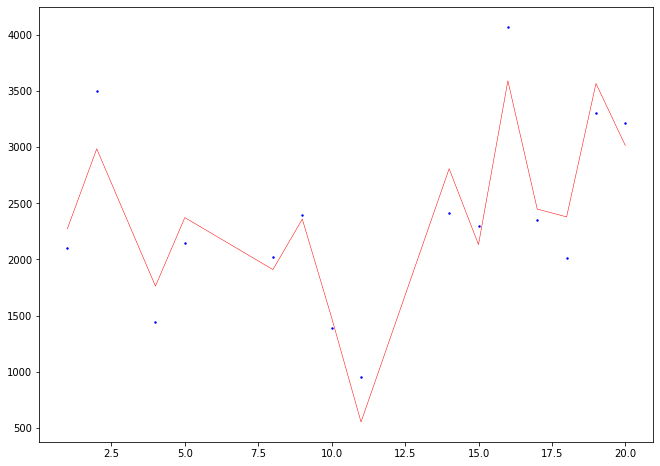

Estimation for lambda: -0.0940940940940942


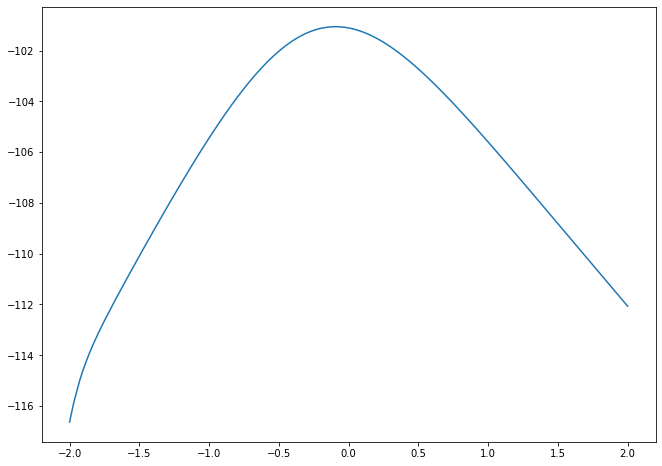

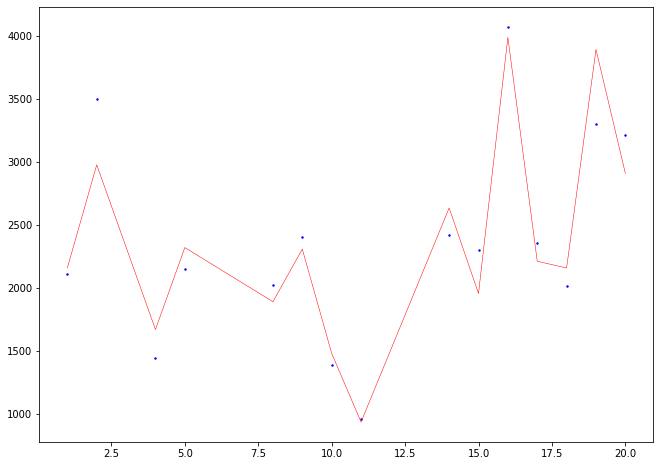

In [4]:
# @title BOX-COX EM y PARA A MÁXIMA VEROSSIMILHANÇA

def log_likelihood(lmbda, x, y):
    n, p = x.shape
    lnjacobi = (lmbda - 1) * np.sum(np.log(y))
    trans_y = stats.boxcox(y, lmbda=lmbda)
    x = sm.add_constant(x)
    c = np.linalg.inv(x.T @ x)
    imxcxt = np.subtract(np.identity(n), (x @ c) @ x.T)
    rss = (trans_y.T @ imxcxt)@trans_y
    
    return - (n / 2.0) * (np.log(rss)) + lnjacobi

regressor = LinearRegression()
regressor.fit(x, y)

mpl.rc("figure", figsize=(11,8))


x = np.squeeze(x)
# Coluna dos dados
if x.ndim > 1:
    xd = df2.iloc[:,0].values

plt.plot(xd, regressor.predict(x), color='red', linewidth=0.5)
plt.scatter(xd, y, color='blue', s=2)
plt.show()


potential_lmbdas = np.linspace(-2, 2, 1000)
likelihoods = np.array([log_likelihood(lmbda, x, y) for lmbda in potential_lmbdas])
plt.plot(potential_lmbdas, likelihoods)

lmb = potential_lmbdas[np.argmax(likelihoods)]
print('Estimation for lambda:',lmb )
plt.show()


# No sklearn, no fit a ordem é X,Y
# Já no ols do statsmodels.api é Y,X

regressor = LinearRegression()
regressor.fit(x, stats.boxcox(y, lmbda=lmb))
plt.plot(xd, special.inv_boxcox(regressor.predict(x), lmb), color='red', linewidth=0.5)
plt.scatter(xd, y, color='blue', s=2)
plt.show()

In [5]:
# from numpy.ma.core import shape
#@title Função para otimizar a transformação Box-Cox

def pbc(n):
    '''
    Função exponencial de n
    '''
    def infct(varin):
        return varin ** n
    return infct

def fntrans(n):
    '''
    Função de tranformação box-cox
    '''
    if n == 0:
        return np.log
    else:
        return pbc(n)

def invtrans(n):
    '''
    Função de tranformação inversa de box-cox
    '''
    if n == 0:
        return np.exp
    else:
        return pbc(1/n)


class bcxreg:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n, self.p = x.shape
        self.model = None

    def bcxmodel(self,lmbda):
        '''
        Método que retorna o modelo de regressão linear tranformado 
        pela função box-cox
        '''
        x, y, p = self.x, self.y, self.p
        trans_x = np.zeros_like(x)
        trans_y = fntrans(lmbda[-1])(y)

        for k in range(p):
            trans_x[:,k] = fntrans(lmbda[k])(x[:,k])

        trans_x = sm.add_constant(trans_x)
        model = sm.OLS(trans_y, trans_x)
        return model.fit()

    def bcxr2(self, lmbda):
        '''
        Função que retorna o R2 (Determinação) da estimativa 
        ou seja, compara y real com o y estimado após a tranformação inversa box-cox
        lambda  : Lista dos valores do expoentes da transformação box-cox.
        x       : Array dos valores das varoáveis independentes
        '''

        y_reg = self.bcxmodel(lmbda).fittedvalues
        y_est = invtrans(lmbda[-1])(y_reg)
        sqt = sum((y - np.mean(y))**2)

        # Resíduos
        rs = y - y_est
        sqe = sum(rs**2)

        r2 = 1 - sqe/sqt
        
        return r2

    def bcxic(self,x0,lmbda):
        p = len(x0)
        trans_x = x0.copy()
        
        for k in range(p):
            trans_x[k] = fntrans(lmbda[k])(x0[k])

        # Retorna a previsão e o CI
        trans_x = np.hstack([1.0, trans_x])
        result = self.bcxmodel(lmbda).get_prediction(trans_x)

        y_ci0 = result.conf_int(alpha = 0.2)[0]
        y_ci = invtrans(lmbda[-1])(y_ci0)

        y_e = invtrans(lmbda[-1])(np.mean(y_ci0))

        return abs(y_ci[1] - y_ci[0])/y_e

In [6]:
# @title BOX-COX EM TODAS AS VARIÁVEIS PARA O MELHOR R2 DA ESTIMATIVA

bc0 = bcxreg(x,y)

def optbcx0(params):
    return -bc0.bcxr2(params)

bnds = [[-2, 2]]*npar

initial_guess = [1]*npar
result_optbcx0 = optimize.minimize(optbcx0, initial_guess, method = 'L-BFGS-B',bounds = bnds)
print(f"O melhor R² da estimativa é {result_optbcx0['fun']:.3f}")


bcxar_r2 = result_optbcx0['x']

print("O vetor de tranformação que gera o melhor R² da estimativa é ",[round(k,3) for k in bcxar_r2])


O melhor R² da estimativa é -0.923
O vetor de tranformação que gera o melhor R² da estimativa é  [-0.175, -0.852, 1.0, -0.41, -0.268]


In [7]:
# @title BOX-COX EM TODAS AS VARIÁVEIS PARA A MENOR AMPLITUDE DO INTERVALO DE CONFIANÇA
def optbcx1(params):
    return bc0.bcxic(av,params)

result_optbcx1 = optimize.minimize(optbcx1, initial_guess, method = 'L-BFGS-B',bounds = bnds)
print(f"A menor amplitude do IC é {result_optbcx1['fun']:.3f}")

bcxar_ic = result_optbcx1['x']

print("O vetor de tranformação que gera o melhor R² da estimativa é ",[round(k,3) for k in bcxar_ic])

# bcxar_ic = np.array([-2.0, 1.0, -2.0, -0.5]) # Caso queira testar algum modelo existente, será o nº 2

A menor amplitude do IC é 0.094
O vetor de tranformação que gera o melhor R² da estimativa é  [0.125, -2.0, 1.0, 1.031, -0.734]


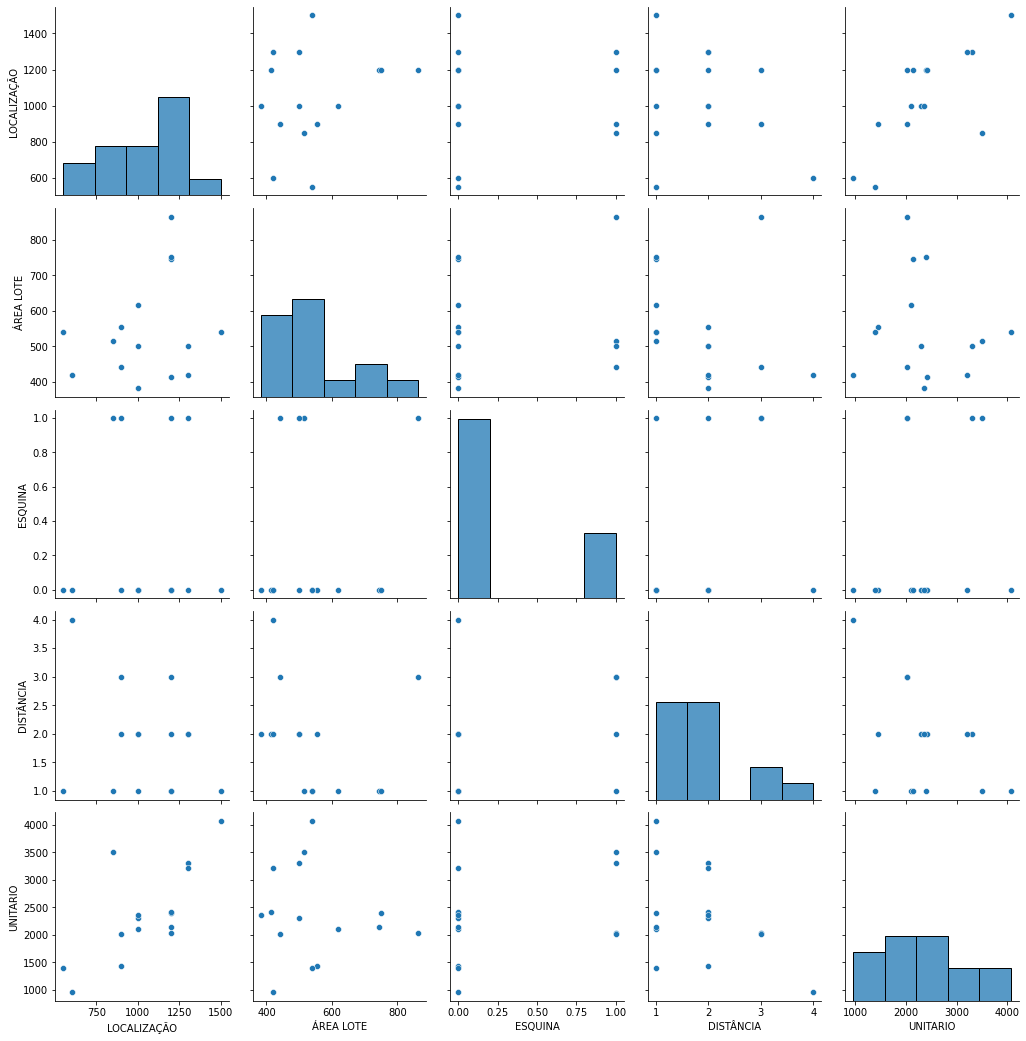

In [8]:
g = sns.pairplot(df2.iloc[:,1:], height = 2)
g.fig.set_size_inches(15,15)

In [9]:
#@title RESUMO

X1 = sm.add_constant(x)

model = sm.OLS(y, X1)
model = model.fit()
print(model.summary(alpha=0.2))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     16.60
Date:                Tue, 16 Aug 2022   Prob (F-statistic):           0.000205
Time:                        12:44:20   Log-Likelihood:                -106.57
No. Observations:                  15   AIC:                             223.1
Df Residuals:                      10   BIC:                             226.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|        [0.1        0.9]
------------------------------------------------------------------------------
const       2167.7044    630.845      3.436      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


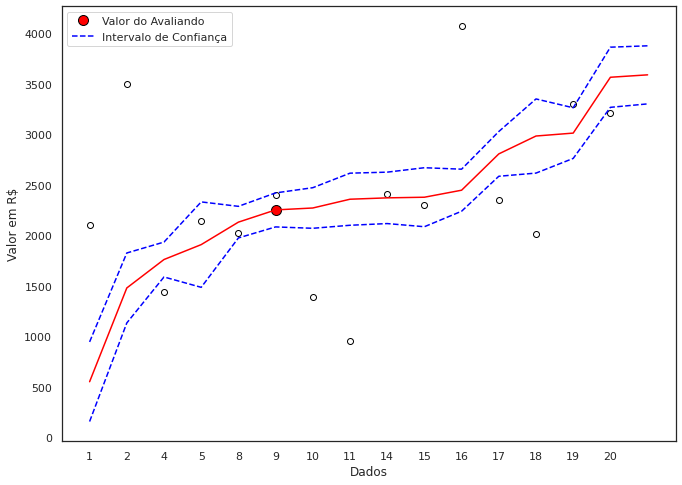

In [10]:
#@title INTERVALO DE CONFIANÇA

dados1 = df2.iloc[:,0].copy(deep=True)

# X do modelo observado com 1 na primeira coluna
# Adicionando os valores do avaliando para verificar
# o intervalo de confiança
X_av = X1.copy()
X_av = np.vstack([X_av, np.hstack([1, av])]).astype(float)

result = model.get_prediction(X_av) # Retorna a previsão e o CI
res_ci = result.conf_int(alpha = 0.2)

# Calculando o preço estimado pela média dos extremos do IC
pm_est = np.array([(res_ci[:,0] + res_ci[:,1])/2]).T

bandas = np.hstack((res_ci,pm_est))

# Ordenando o array pela ultima coluna
bandas_ord = bandas[bandas[:, -1].argsort()]

sns.set(style="white")
plt.figure(num = 2, figsize=(11, 8))
plt.plot(range(len(x)), y, linestyle = "None", marker = "o",
         markerfacecolor = "None", color = "black")

# Marcando o valor do avaliando em vermelho
plt.plot(np.where(bandas_ord == bandas[-1])[0][0], pm_est[-1], linestyle = "None", marker = "o",
         markerfacecolor = "red", color = "red",mec = 'black',ms = 10, label="Valor do Avaliando")

# Limites inferiores e superiores do intervalo de confiança
plt.plot(range(len(X_av)), bandas_ord[:,2], color = "red")
plt.plot(range(len(X_av)), bandas_ord[:,0], color = "blue", linestyle = "--", label = 'Intervalo de Confiança')
plt.plot(range(len(X_av)), bandas_ord[:,1], color = "blue", linestyle = "--")

plt.xticks(range(len(x)), dados1.values.astype(int))
plt.xlabel("Dados")
plt.ylabel("Valor em R$")

plt.legend(loc="best")
plt.show()

In [11]:
#@title VALOR MÍNIMO, VALOR ESTIMADO E VALOR MÁXIMO NO INTERVALO DE CONFIANÇA DE 80%

aval = np.sort(bandas[-1])
print(aval)

amp0 = ((aval[2] - aval[0])/aval[1])

print(f"A amplitude do intervalo de Confiança de 80% é de {amp0:.2%}")

[2085.2892973  2253.60446333 2421.91962935]
A amplitude do intervalo de Confiança de 80% é de 14.94%


## Linearidade

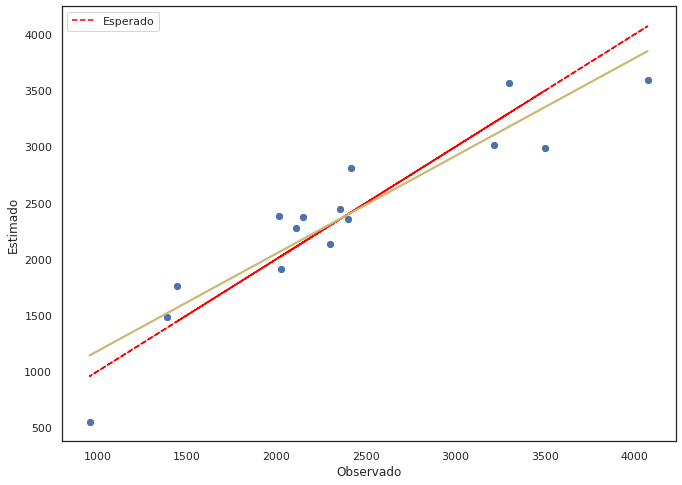

In [12]:
#@title ANÁLISE DA LINEARIDADE

plt.gcf().set_size_inches(11, 8)
# model.predict(X) e model.fittedvalues opção iguais, mas a model.fittedvalues já é calculada
prevs = model.fittedvalues

data_results = pd.DataFrame({'Actual': y, 'Predicted': prevs})

# -> Plotando a relação entre o real e o previsto
# sns.lmplot(x='Actual', y='Predicted', data = data_results, fit_reg = False)
plt.scatter(y,prevs)

# -> Plotando linha diagonal
plt.plot(y, y, color='red', linestyle='--', label = 'Esperado')

dfregy2 = pd.DataFrame({'x': y, 'y': prevs})
sns.regplot(x="x", y="y", data = dfregy2, line_kws={"color": "y"}, ci = None)

plt.xlabel("Observado")
plt.ylabel("Estimado")
plt.legend()
plt.show()

## Normalidade

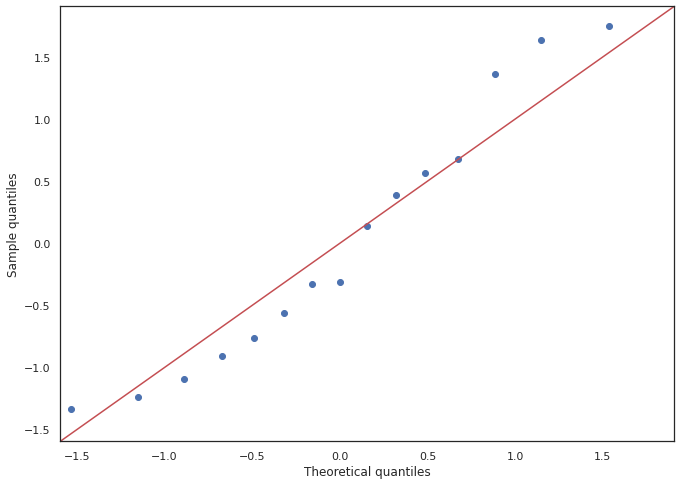

In [13]:
#@title ANÁLISE DA NORMALIDADE QQPLOT

# model.mse_resid # MSE

# (Y-prevs).std(ddof=2) # rmse = (model.mse_resid)**0.5
erros_rel = model.resid_pearson # Resíduo de Pearson = erros/rmse

# mpl.rc("figure", figsize=(11.8,8))
# sns.set(style="white")
plt.rc("figure", figsize=(11,8))

fig = qqplot(erros_rel, line='45',fit='True')
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()

HOMOCEDASTICIDADE PELA ANÁLISE DOS ERROS DE PEARSON:

$$ϵ_{pi} = \frac{ϵ}{RMSE} = \frac{ϵ}{\sigma_{mod}} $$

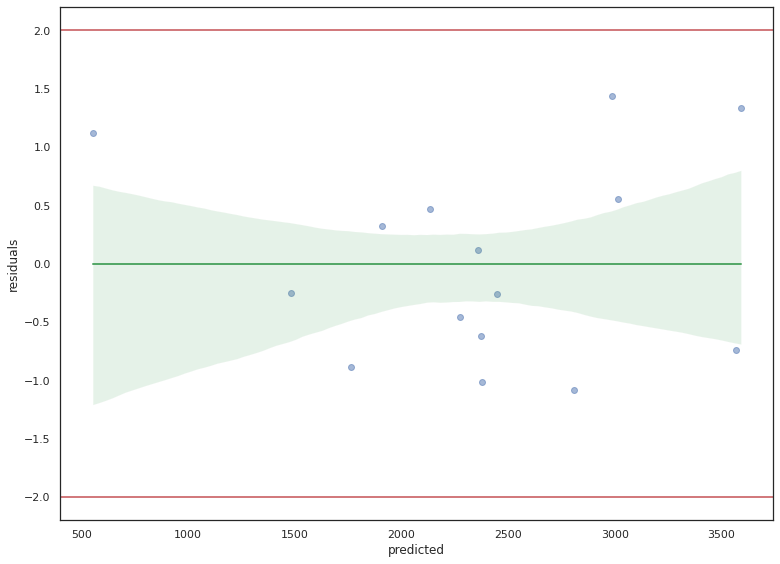

Os Dados indicados como outliers são apresentados abaixo


,Dado,LOCALIZAÇÃO,ÁREA LOTE,ESQUINA,DISTÂNCIA,UNITARIO


In [14]:
#@title HOMOCEDASTICIDADE

# Plotando todos os erros
data_hm = {'x':prevs,'y':erros_rel}
fig, ax = plt.subplots(figsize=(11, 8))
sns.regplot(data = data_hm, x='x',y='y', scatter_kws={'alpha': 0.5}, line_kws={'color': 'C2', 'lw': 2},ci = 80 ,ax=ax)


# Plotando os erros outliers
lprev = []
lerr = []
for j,k in zip(erros_rel,prevs):
    if abs(j) > 2:
        lprev.append(k)
        lerr.append(j)

data_hm_o = {'x':lprev,'y':lerr}
sns.scatterplot(data = data_hm_o, x='x',y='y',color = 'r')
ax.axhline(2.0, linestyle='-', color='r')
ax.axhline(-2.0, linestyle='-', color='r')

ax.set_xlabel('predicted')
ax.set_ylabel('residuals')
plt.tight_layout()
plt.show()

print("Os Dados indicados como outliers são apresentados abaixo")

df2[np.logical_or((erros_rel < -2),(erros_rel > 2))]

## **ESTATÍSTICA DE DURBIN WATSON**

Estatística que varia entre 0 e 4.<br>
O valor de d = 2 indica nenhuma autocorrelação <br>
Valores entre 0 e 2 indicam uma autocorrelação positiva e valores entre 2 e 4 indicam uma autocorrelação negativa.

Em nosso caso a estatística de Durbin-Watson é aproximadamente igual a 2, uma boa indicação de a hipótese de autocorrelação não é violada.

O valor da estatística de Durbin-Watson é aproximadamente igual a 2*(1-r), no qual r é a correlação dos resíduos.

Logo, para r = 0 é observa-se nenhuma correlação entre os resíduos, o que geraria um valor da estatística d = 2.

$$ d = \dfrac{\sum_{i = 2}^N (\widehat{\epsilon}_i - \widehat{\epsilon}_{i-1})^2}{\sum_{i = 1}^N \widehat{\epsilon}_i^2} $$

In [15]:
#@title VALOR DA ESTATÍSTICA DE DURBIN WATSON

erros = model.resid

durbinWatson = durbin_watson(erros)
print(durbinWatson)

2.4884248485172766


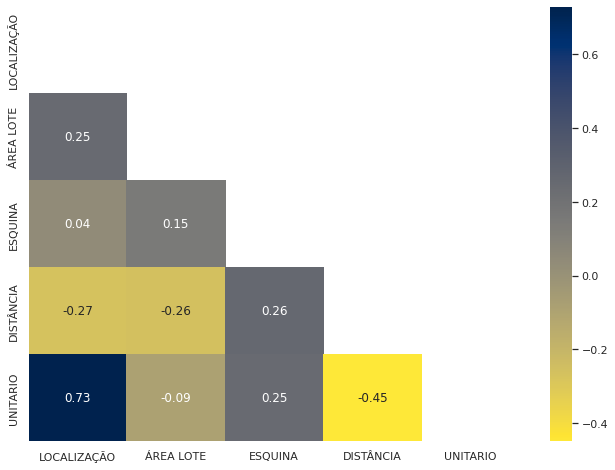

In [16]:
#@title MULTICOLINEARIDADE
co_mtx = df2.iloc[:,1:].corr()
if len(co_mtx) > 1:
    mask = np.zeros_like(co_mtx)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(co_mtx.round(2), annot=True, mask=mask, cmap="cividis_r");

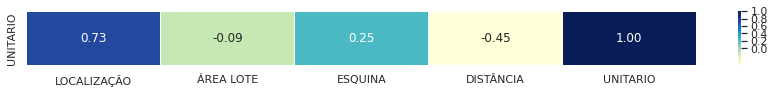

In [17]:
#@title MATRIZ CORRELAÇÃO RESUMIDA
dft0 = df2.iloc[:,1:]

plt.subplots(figsize=(15,1))
sns.heatmap(dft0.corr().iloc[-1:], annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, cbar_kws={'ticks':[k*0.2 for k in range(6)]});

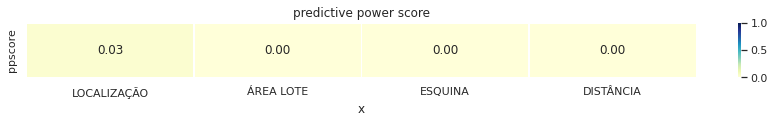

In [18]:
#@title Predictive Power Score

def pps_matrix(dtf, annotation=True, figsize=(10,5)):
    dtf_pps = ppscore.matrix(dtf)
    dtf_pps = dtf_pps[dtf_pps['y']== dtf.columns[-1]]

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(dtf_pps.iloc[:-1,[0,2]].set_index('x').T, vmin=0., vmax=1., annot=annotation, fmt='.2f', cmap="YlGnBu", ax=ax, cbar=True, linewidths=0.5)
    plt.title("predictive power score")
    return dtf_pps

pps = pps_matrix(dft0, figsize=(15,1))

In [19]:
dtf_pps = ppscore.matrix(dft0)
dtf_pps = dtf_pps[dtf_pps['y'] == dft0.columns[-1]]
dtf_pps

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
4,LOCALIZAÇÃO,UNITARIO,0.029459,regression,True,mean absolute error,611.850244,593.825589,DecisionTreeRegressor()
9,ÁREA LOTE,UNITARIO,0.000000,regression,True,mean absolute error,611.850244,1312.011210,DecisionTreeRegressor()
14,ESQUINA,UNITARIO,0.000000,regression,True,mean absolute error,611.850244,683.081208,DecisionTreeRegressor()
19,DISTÂNCIA,UNITARIO,0.000000,regression,True,mean absolute error,611.850244,664.088007,DecisionTreeRegressor()
24,UNITARIO,UNITARIO,1.000000,predict_itself,True,None,0.000000,1.000000,None


Resíduos Studentizados

$$ r_{i}=\dfrac{ϵ_{i}}{s(ϵ_{i})}=\dfrac{ϵ_{i}}{\sqrt{MSE(1-h_{ii})}} $$

Por ter uma distribuição t de Student, os valores maiores que 3 são indicação de outlier, observamos abaixo os valores que ultrapassem 2.5

In [20]:
#@title RESÍDUOS STUDENTIZADOS

influence = OLSInfluence(model)

# Vetor com o valor das distancias de cook e p-valor (Quanto mais próximo de 1 melhor)
distck = influence.cooks_distance

diagH = influence.hat_matrix_diag
res_t = influence.resid_studentized_internal

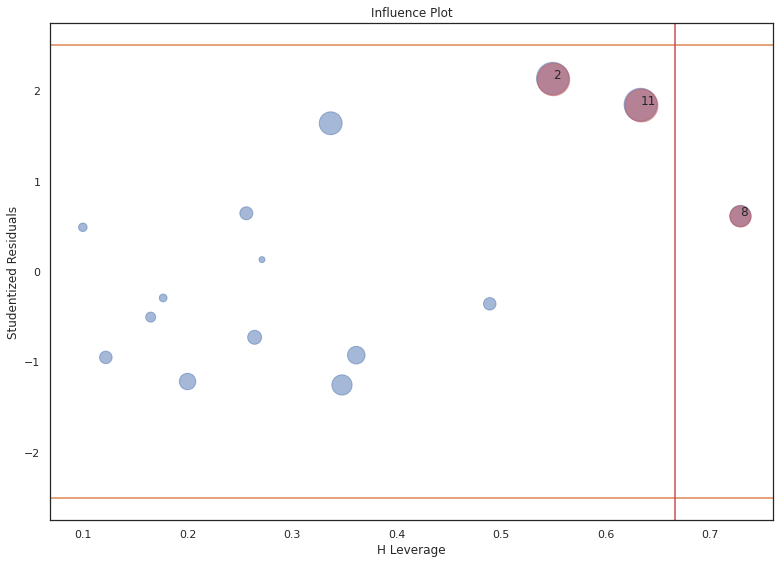

In [21]:
#@title PONTOS INFLUENCIANTES

def leverage_inf(mod):

    influence = OLSInfluence(model)

    # Vetor com o valor das distancias de cook e p-valor (Quanto mais próximo de 1 melhor)
    distck = influence.cooks_distance


    fig, ax = plt.subplots(figsize=(11, 8))
    ax.axhline(-2.5, linestyle='-', color='C1')
    ax.axhline(2.5, linestyle='-', color='C1')

    diagH = influence.hat_matrix_diag
    res_t = influence.resid_studentized_internal

    # model.df_model # Grau de liberdade do modelo = npar -1
    npar = model.df_model + 1
    ndados = model.nobs
    thsh_H = 2 * npar / ndados # threshold da alavancagem

    ax.scatter(diagH, res_t, s=1000*np.sqrt(distck[0]), alpha=0.5)

    for i, txt in enumerate(df2.Dado):
        if np.any([distck[0][i] > 1, diagH[i] > thsh_H, abs(res_t[i])>2.5]):
            ax.scatter(diagH[i], res_t[i], s=1000*np.sqrt(distck[0][i]), alpha=0.5, color = 'r')
            ax.annotate(int(txt), (diagH[i], res_t[i]))

    ax.axvline(thsh_H, linestyle='-', color='r')

    ax.set_xlabel('H Leverage')
    ax.set_ylabel('Studentized Residuals')
    ax.set_title("Influence Plot")
    plt.tight_layout()
    plt.show()

    # O mesmo gráfico com biblioteca pronta
    # sm.graphics.influence_plot(model)
    # plt.show()

leverage_inf(model)

**Distância de Cook**

$$ D_i = \frac{ϵ_{i}^{2}}{s^{2} p}\left[\frac{h_{ii}}{(1-h_{ii})^2}\right] $$

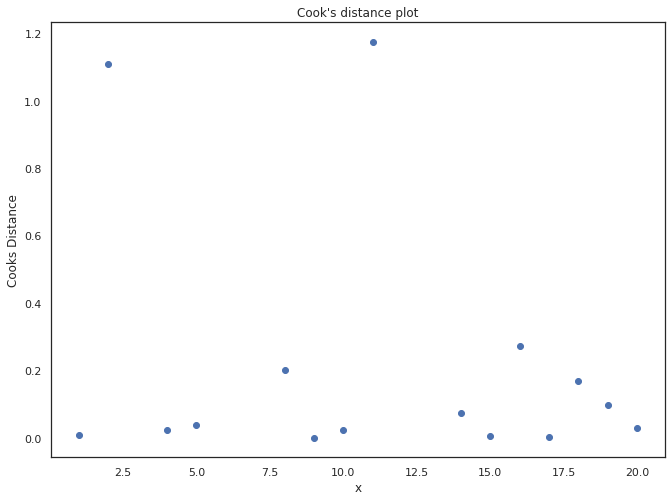

In [22]:
#@title PONTOS INFLUENCIANTES (DISTÂNCIA DE COOK)

# (Distância de Cook manualmente)
# infl = model.get_influence()
# sm_fr = infl.summary_frame()

# msr = model.mse_resid
# rmse = (msr)**0.5

# Distância de Cook manualmente
# dist_cook = [ (erros[i]**2) * sm_fr['hat_diag'][i] / ( npar*msr*((1-sm_fr['hat_diag'][i])**2) ) for i in range(len(X))]

influence = OLSInfluence(model)
distck = influence.cooks_distance

fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(df2.Dado,distck[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.title("Cook's distance plot")
plt.show()

In [23]:
#@title ANÁLISE DAS COMPONENTES PRINCIPAIS

ndados, nvar = x.shape

X_scaled = (x - x.mean(axis = 0))/x.std(axis=0, ddof=1)

if nvar >= 2:
    pca = PCA(n_components = nvar)
    pca.fit(X_scaled)
    print("Peso das componentes principais", [f'{k:.2%}'for k in pca.explained_variance_ratio_])
    # Matriz de escores
    principalComponents = pca.fit_transform(X_scaled)
    # Matriz de pesos
    display(pd.DataFrame([[np.corrcoef(X_scaled[:,j],
                                       principalComponents[:,k])[0][1] for k in range(nvar)] for j in range(nvar)],
                         columns = [f'PC{k}' for k in range(nvar)], index = df2.iloc[:,1:-1].columns))

Peso das componentes principais ['38.15%', '29.73%', '18.61%', '13.51%']


,PC0,PC1,PC2,PC3
LOCALIZAÇÃO,-0.698006,0.194145,-0.673723,-0.145574
ÁREA LOTE,-0.667983,0.426795,0.512722,-0.329790
ESQUINA,0.140049,0.904837,-0.026983,0.401158
DISTÂNCIA,0.756868,0.388291,-0.163826,-0.499542


In [24]:
#@title CORPO DO CÓDIGO

# Definindo as cores de destaque dos prints
RED = '\033[91m'
BLACK = '\033[90m'
BOLD = '\033[1m'
DEFOUT = '\x1b[0m'

def rglmv(dd_ar,avf):

    '''
    Função para o cálculo das principais métricas de regressão linear
    dd_ar : Array da tabela dos valores das variáveis idenpendentes (X) e em sua ultima coluna os
    valores das variáveis dependentes (Y)
    '''
    # npar : Número de Parametros = nv+1 | nv : Número de Variáveis/Feature | nd : Número de Dados
    ndados, npar = dd_ar.shape
    nvar = npar - 1

    #Vetor dos valores totais 'ou unitários' (Var Dependente)
    y = dd_ar[:,-1].copy()

    x = dd_ar[:,:-1].copy()
    x = sm.add_constant(x)

    # Transposta do Vetor das observações das variáveis explicativas
    xt = x.T

    ci = (x.T)@x    # O mesmo efeito que np.matmul(xt, x), mas aceita dataframes
                    # Matriz Gram
                    # Essa solução só será possível quando X′X é de posto completo, é não singular e admite inversa.
                    # A inversa da Matriz C que é parte da matriz de covariancia do estimador beta
                    # cov(beta) = (sigma ** 2)*C

    if np.linalg.det(ci) != 0:
        c = np.linalg.inv(ci) # cov(beta) = (sigma ** 2)*C
    else:
        return 0

    xty = xt @ y
    b = c @ xty                         # Vetor dos coeficientes regressores
    yreg = x @ b                        # Vetor das estimativas
    ssy = y.T @ y                        # Soma dos quadrados do valores observados
    ssr = ssy - yreg @ y                # Soma dos quadrados dos erros | Soma de Quadrados Residual
    sso = (ndados)*((np.mean(y))**2)    # Soma dos quadrados do valor médio
    sst = ssy - sso                     # Soma dos quadrados totais
    sse = sst - ssr                     # Soma dos quadrados do regressão | Variabilidade Explicada
    r2 = 1 - (ssr / sst)                # Coeficiente de determinação R²

    # Grau de liberdade Residual | Numero de dados - Número de parametros (nv + 1 = qtd de coeficientes + constante)
    gle = ndados - npar

    msr = ssr / gle         # Erro médio residual
    mse = sse / (npar - 1)  # Erro médio
    mst = sst/(ndados- 1)   # Erro médio total
    F = mse / msr

    Se = msr**0.5

    dpb = [abs(b[i]/(Se*np.sqrt(c[i][i]))) for i in range(npar)]  # Valores relativos dos erros dos regressores' - Teste t
                                                                  # Depende dos valores da diagonal da matriz 

    sig = [(1-stats.t.cdf(dpb[i],df = gle))*2 for i in range(npar)] # Valores das significâncias dos testes t Bicaudal

    # Máxima siginificância, desconsiderando o intercepto
    psig = max(sig[1:])

    sigF = 1 - stats.f.cdf(F, dfn = npar - 1, dfd = gle)

    avf = np.array(avf)
    avf = np.append([1], avf, axis=0)

    #Valor estimado do imóvel
    vav = b.dot(avf)

    avc = np.matmul(avf,c)
    Ve = np.matmul(avc,avf)*(msr)      # Variancia da estimativa

    # Valor do p-valor para o qual a probabilidade seja menor que 80% bicaudal.
    t6 = stats.t.ppf(0.9, df = gle)
    # Metade do intervalo de confiança
    sic = t6 * (Ve**0.5)            

    vmin = vav - sic
    vmax = vav + sic

    ampic = 2 * sic / vav

    lst_keys = ['x','yreg','r2','psig','ampic','b','gle','Se','sig','sigF','F','vav','vmin','vmax',
                'Ve','c','msr','sse','sst','ssr']
    
    retorno = [x,yreg,r2,psig,ampic,b,gle,Se,sig,sigF,F,vav,vmin,vmax,Ve,c,msr,sse,sst,ssr]

    dicionario = dict(zip(lst_keys, retorno)) #{k:j for k,j in zip(lst_keys , retorno)}

    return dicionario
        
################################################################

# FUNÇÃO PARA O TESTE QUI-QUADRADO
def chisqr(data, signf = 0.05):

    print(f'{BOLD}{RED}TESTE DE QUI-QUADRADO')

    f_obs, bins = np.histogram(data, bins = 'auto')

    # Frequencia acumulada esperada
    xf_cum = norm.cdf(bins, loc = data.mean() , scale = data.std(ddof = 1))

    # Cálculo da Frequência relativa esperada
    f_exp_rel = ((np.roll(xf_cum, -1) - xf_cum)[:-1]) * len(data) 

    # Cálculo da Frequência absoluta esperada
    f_exp_abs = f_exp_rel  * len(data) / (f_exp_rel.sum())

    statistic_n, pvalue_n = chisquare(f_obs, f_exp = f_exp_abs)

    print(f'{DEFOUT}Estatística Qui-quadrado: {statistic_n:.3f}')
    print(f'p-valor do teste: {pvalue_n:.3%}')

    if pvalue_n > signf:
        print('Amostra semelhante a uma gaussiana (falha em rejeitar H0)')
    else:
        print('Amostra não se assemelha a uma gaussiana  (rejeita H0)')

################################################################

# Transformando para o padrão Brasileiro
def usd2rls(s):
    'Função que recebe um float e converte em uma string numérica no formato pt-br'
    return f'{s:,.2f}'.replace(",","@").replace(".",",").replace("@",".")

################################################################

# Para guardar a identificação de cada dado
dados = df2.iloc[:,0].copy().values.astype(int)

# Dados do DataFrame de entrada em array
dd = df2.iloc[:,1:].copy().values

resultado = rglmv(dd,av)

#....................................# Mudança de Variável

ndados, npar = df2.shape    # npar : Número de Parametros | nv : Número de Variáveis/Feature | nd : Número de Dados
npar = npar - 1

exc0 = np.where(df2 == 0)[1]     # Pesquisa a localizacao dos valores negativos ou nulos no dataframe e retorna as colunas onde se encontram
exc0 = set(exc0)                 # excl sera formado epenas pelas colunas que tem valor nulo ou negativo

exc_neg = np.where(df2 < 0)[1]     # Pesquisa a localizacao dos valores negativos ou nulos no dataframe e retorna as colunas onde se encontram
exc_neg = set(exc_neg)             # excl sera formado epenas pelas colunas que tem valor nulo ou negativo


# Vetores que representam cada modelo
mod = np.ones(npar)
for i in [bcxar_r2, bcxar_ic]:
    if not np.isin(i,mod).all():
        mod = np.vstack((mod, i))

ex_bcx = [-2.0, -1.0, -0.5, 0, 0.5, 1.0, 2.0]

if npar <= 5:                                               
    prod_carte = np.array(list(itertools.product(ex_bcx, repeat = npar)))
    mod = np.vstack((mod, prod_carte))
else:
    # Caso existam muitas variaveis a condição reduz os calculos 
    # para uma amostra dos modelos gerados de uma forma probabilistíca
    prod = np.random.choice(ex_bcx, size = ((7**5),npar))
    mod = np.vstack((mod, prod))

modf = mod.copy()

for j in exc0:
    # Pus j-1, pois df2 tem uma coluna a mais (A coluna que identifica os dados).
    modf = modf[~np.in1d(modf[:,j-1], [-2.0, -1.0, -0.5, 0])]
for i in exc_neg:
    modf = modf[~np.in1d(modf[:,i-1], [-0.5, 0, 0.5])]

# Lista com os dados transformados
# Mudança de variáveis
lst_dd = []
lst_av = []


# Dados do avaliando em array
avar = np.copy(av)

for k in modf:
    trans_dd = np.copy(dd)
    trans_av = np.copy(av)
    for i in range(npar):
        try:
            trans_dd[:,i] = fntrans(k[i])(dd[:,i])
        except:
            print("Erro na transformação dos dados")

        # Nos dados do avaliando, só não tranforma a coluna da
        # varipavel dependente pois não existe
        if i != (npar-1):
            try:
                trans_av[i] = fntrans(k[i])(avar[i])
            except:
                print("Erro na transformação dos dados do avaliando")

    lst_dd.append(trans_dd)
    lst_av.append(trans_av)

#...................................#
lst_modelos = []
k = 0
lista_drop = []

# Filtrando apenas os resultados mais relevantes
lst_stat = ['r2', 'psig', 'ampic','Se','sigF', 'F', 
            'vav', 'vmin', 'vmax', 'Ve','msr', 'sse', 'sst']

# Geração dos modelos para cada conjunto de dados
# lst_modelos armazena os resultados das regressões
for dd_k,av_k in zip(lst_dd,lst_av):
    result_reg = rglmv(dd_k,av_k)
    if result_reg != 0:
        lst_modelos.append(result_reg)

    # Inserindo uma linha de 0 (zeros) para seguir a mesma numeração do modf
    # Retirando modelos com matrizes  singulares
    else:
        lst_modelos.append({x: 0 for x in lst_stat})
        lista_drop.append(k);
    k+=1

# Criação do dataframe com as estatistícas das regressões de cada modelo
df_stat = pd.DataFrame()

for k in lst_modelos:
    dfmod = pd.DataFrame([{x: k[x] for x in lst_stat}])
    df_stat = pd.concat([df_stat,dfmod])
    
df_stat.reset_index(drop = True, inplace = True)


# Retirando modelos com matrizes  singulares
# Sem perder a mesma ordem que o modf e lst_dd
df_stat.drop(lista_drop,inplace=True)

yest_list=[]

# Lista dos valores estimados do ímovel
VavE_l=[]
VEMin_l=[]
VEMax_l=[]

# Como o modf e df_stat tem correpondência
# Vamos tirar os modelos inadequados
id0 = df_stat.index
lst_modelos2 = [lst_modelos[x] for x in id0]
modf2 = [modf[x] for x in id0]

# Lista com modelos com algum erro na tranformação inversa
lerro = []

for j,k,cnt in zip(lst_modelos2, modf2, id0):
    yregt, vavt, vmin, vmax  = j['yreg'], j['vav'], j['vmin'], j['vmax']

    # Para evitar números negativos no resultado da regressão
    yregt_bool = all(yregt >= 0) and all(np.array([vavt,vmin,vmax]) >= 0)

    # Valor estimado dos dados
    # Desfazendo a troca de variaveis para achar o valor estimado dos dados
    finv = invtrans(k[-1])
    try:
        yest_list.append(finv(yregt))
        VavE_l.append(finv(vavt))
        VEMin_l.append(finv(vmin))
        VEMax_l.append(finv(vmax))
    except:
        lerro.eppend(cnt)

# Filtrando os modelos excluidos por erro na transformação inversa
df_stat.drop(lerro,inplace=True)
id1 = df_stat.index

lst_modelos2 = [lst_modelos[x] for x in id1]
modf2 = [modf[x] for x in id1]

##############################################################
#y = df2.iloc[:,-1] # Valores das observados originais

sst = resultado['sst']

Eest=[]                                 # Erro da estimativa
SQE_l=[]                                # Soma dos quadrados da Estimativa

for k in yest_list:
    Eest.append(y-k)
    SQE_l.append(sum((y-k)**2))
    

R2E_l=[]                                # Coeficiente de determinação da Estimativa
for k in range(len(yest_list)):
    R2E_l.append(1- (SQE_l[k]/sst));


df_stat[['VaV_est', 'Vmin_est','Vmax_est','R2_est']] = pd.DataFrame([VavE_l, VEMin_l, VEMax_l,R2E_l], 
                                                                    columns = df_stat.index).T # Adicionando os valores da estimativa de valor

df_stat['Amp_est'] = abs((df_stat.Vmax_est - df_stat.Vmin_est) / df_stat.VaV_est)

ord_lst = [*range(len(VavE_l))]
df_stat.sort_values(by=['psig'], inplace = True)
df_stat.insert(1, 'Nota_sig', ord_lst)

df_stat.sort_values(by=['R2_est'], inplace = True, ascending = False)
df_stat.insert(18, 'Nota_R2_est', ord_lst)

df_stat.sort_values(by=['Amp_est'], inplace = True)
df_stat.insert(20, 'Nota_Amp_est', ord_lst)

df_stat['Nota_Comb'] = df_stat['Nota_sig'] + df_stat['Nota_R2_est'] + df_stat['Nota_Amp_est']


df_stat2 = df_stat[['r2','Nota_sig', 'psig',  'sigF', 'F', 'VaV_est', 'Vmin_est',
            'Vmax_est', 'R2_est', 'Nota_R2_est', 'Amp_est', 'Nota_Amp_est',
            'Nota_Comb']]

# Excluindo as linhas com valores ausentes
df_stat2.dropna(inplace = True)

df_stat2.sort_values(by=['Nota_Comb'],inplace = True, ascending = True)
print(BOLD+RED+"Os Modelos com melhores combinações de determinação,Siginificância e Amplitude")
display(df_stat2.head(10).style.format({'Amp_est': '{:,.2%}','psig': '{:,.2%}'.format}))

print("Indique os valores limites, ou simplesmente clique Enter para prosseguir")
det_min = float(input("Qual o valor minimo de R² da estimativa: ") or "0.6")
sig_max = float(input("Qual o valor maximo de significancia: ") or "0.1")
amp_max = float(input("Qual o valor maximo de amplitude do intervalo de confianca: ") or "0.3")
print("Os valor limites de determinação,Siginificância e Amplitude são respectivamente {:,.2%},{:,.2%} e {:,.2%}".
      format(det_min,sig_max,amp_max))

print(BOLD+RED+"Os Modelos que atendem aos critérios da NBR 14.653")
dfnbr = df_stat2[df_stat2['R2_est'] >= det_min]
dfnbr = dfnbr[dfnbr['psig'] <= sig_max]
dfnbr = dfnbr[dfnbr['Amp_est'] <= amp_max]
display(dfnbr.head(10).style.format({'Amp_est': '{:,.2%}','psig': '{:,.2%}'.format}))

print(BOLD+RED+"Os Modelos com melhores R²")
display(df_stat2.sort_values(by=['R2_est'],ascending = False).head(10).style.format(
    {'Amp_est': '{:,.2%}','psig': '{:,.2%}'.format}))

print(BOLD+RED+"Os Modelos com melhores Significância")
display(df_stat2.sort_values(by=['psig']).head(10).style.format(
    {'Amp_est': '{:,.2%}','psig': '{:,.2%}'.format}))

print(BOLD+RED+"Os Modelos com menor amplitude de Intervalo de Confiança")
display(df_stat2.sort_values(by=['Amp_est']).head(10).style.format(
    {'Amp_est': '{:,.2%}','psig': '{:,.2%}'.format}))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


Os Modelos com melhores combinações de determinação,Siginificância e Amplitude


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,r2,Nota_sig,psig,sigF,F,VaV_est,Vmin_est,Vmax_est,R2_est,Nota_R2_est,Amp_est,Nota_Amp_est,Nota_Comb
4339,0.938810,5,0.04%,0.000005,38.356578,2004.632080,1901.492787,2113.365774,0.921729,10,10.57%,160,175
4290,0.938810,3,0.04%,0.000005,38.356578,2004.632080,1901.492787,2113.365774,0.921729,12,10.57%,161,176
4388,0.938810,4,0.04%,0.000005,38.356578,2004.632080,1901.492787,2113.365774,0.921729,11,10.57%,162,177
4437,0.939433,1,0.04%,0.000005,38.776384,2014.990642,1911.176747,2124.443641,0.921539,16,10.58%,167,184
4535,0.939433,0,0.04%,0.000005,38.776384,2014.990642,1911.176747,2124.443641,0.921539,17,10.58%,168,185
4486,0.939433,2,0.04%,0.000005,38.776384,2014.990642,1911.176747,2124.443641,0.921539,18,10.58%,166,186
2231,0.942688,79,0.06%,0.000004,41.120573,1999.589119,2109.049009,1898.434719,0.921107,25,10.53%,146,250
2280,0.942688,80,0.06%,0.000004,41.120573,1999.589119,2109.049009,1898.434719,0.921107,26,10.53%,145,251
2329,0.942688,81,0.06%,0.000004,41.120573,1999.589119,2109.049009,1898.434719,0.921107,27,10.53%,147,255
4584,0.938757,6,0.04%,0.000005,38.320858,2022.801146,1917.456617,2133.933274,0.919617,44,10.70%,217,267


Indique os valores limites, ou simplesmente clique Enter para prosseguir
Qual o valor minimo de R² da estimativa: 0.9
Qual o valor maximo de significancia: 0.05
Qual o valor maximo de amplitude do intervalo de confianca: 0.15
Os valor limites de determinação,Siginificância e Amplitude são respectivamente 90.00%,5.00% e 15.00%
Os Modelos que atendem aos critérios da NBR 14.653


,r2,Nota_sig,psig,sigF,F,VaV_est,Vmin_est,Vmax_est,R2_est,Nota_R2_est,Amp_est,Nota_Amp_est,Nota_Comb
4339,0.938810,5,0.04%,0.000005,38.356578,2004.632080,1901.492787,2113.365774,0.921729,10,10.57%,160,175
4290,0.938810,3,0.04%,0.000005,38.356578,2004.632080,1901.492787,2113.365774,0.921729,12,10.57%,161,176
4388,0.938810,4,0.04%,0.000005,38.356578,2004.632080,1901.492787,2113.365774,0.921729,11,10.57%,162,177
4437,0.939433,1,0.04%,0.000005,38.776384,2014.990642,1911.176747,2124.443641,0.921539,16,10.58%,167,184
4535,0.939433,0,0.04%,0.000005,38.776384,2014.990642,1911.176747,2124.443641,0.921539,17,10.58%,168,185
4486,0.939433,2,0.04%,0.000005,38.776384,2014.990642,1911.176747,2124.443641,0.921539,18,10.58%,166,186
2231,0.942688,79,0.06%,0.000004,41.120573,1999.589119,2109.049009,1898.434719,0.921107,25,10.53%,146,250
2280,0.942688,80,0.06%,0.000004,41.120573,1999.589119,2109.049009,1898.434719,0.921107,26,10.53%,145,251
2329,0.942688,81,0.06%,0.000004,41.120573,1999.589119,2109.049009,1898.434719,0.921107,27,10.53%,147,255
4584,0.938757,6,0.04%,0.000005,38.320858,2022.801146,1917.456617,2133.933274,0.919617,44,10.70%,217,267


Os Modelos com melhores R²


,r2,Nota_sig,psig,sigF,F,VaV_est,Vmin_est,Vmax_est,R2_est,Nota_R2_est,Amp_est,Nota_Amp_est,Nota_Comb
1,0.938726,27,0.05%,0.000005,38.300493,1989.644592,2101.503853,1885.228025,0.923496,0,10.87%,292,319
2224,0.935818,205,0.08%,0.000006,36.451521,1967.283807,2082.834631,1861.088621,0.922500,1,11.27%,498,704
2273,0.935818,206,0.08%,0.000006,36.451521,1967.283807,2082.834631,1861.088621,0.922500,2,11.27%,499,707
2322,0.935818,207,0.08%,0.000006,36.451521,1967.283807,2082.834631,1861.088621,0.922500,3,11.27%,497,707
3401,0.935660,51,0.06%,0.000006,36.355924,2023.222798,1913.246428,2139.520780,0.922127,4,11.18%,440,495
3450,0.935660,49,0.06%,0.000006,36.355924,2023.222798,1913.246428,2139.520780,0.922127,5,11.18%,442,496
3499,0.935660,50,0.06%,0.000006,36.355924,2023.222798,1913.246428,2139.520780,0.922127,6,11.18%,441,497
4283,0.934458,17,0.05%,0.000007,35.643474,1968.350039,1861.440538,2081.399753,0.921808,7,11.17%,426,450
4332,0.934458,15,0.05%,0.000007,35.643474,1968.350039,1861.440538,2081.399753,0.921808,8,11.17%,425,448
4381,0.934458,16,0.05%,0.000007,35.643474,1968.350039,1861.440538,2081.399753,0.921808,9,11.17%,427,452


Os Modelos com melhores Significância


,r2,Nota_sig,psig,sigF,F,VaV_est,Vmin_est,Vmax_est,R2_est,Nota_R2_est,Amp_est,Nota_Amp_est,Nota_Comb
4437,0.939433,1,0.04%,0.000005,38.776384,2014.990642,1911.176747,2124.443641,0.921539,16,10.58%,167,184
4535,0.939433,0,0.04%,0.000005,38.776384,2014.990642,1911.176747,2124.443641,0.921539,17,10.58%,168,185
4486,0.939433,2,0.04%,0.000005,38.776384,2014.990642,1911.176747,2124.443641,0.921539,18,10.58%,166,186
4339,0.938810,5,0.04%,0.000005,38.356578,2004.632080,1901.492787,2113.365774,0.921729,10,10.57%,160,175
4290,0.938810,3,0.04%,0.000005,38.356578,2004.632080,1901.492787,2113.365774,0.921729,12,10.57%,161,176
4388,0.938810,4,0.04%,0.000005,38.356578,2004.632080,1901.492787,2113.365774,0.921729,11,10.57%,162,177
4633,0.938757,8,0.04%,0.000005,38.320858,2022.801146,1917.456617,2133.933274,0.919617,45,10.70%,219,272
4584,0.938757,6,0.04%,0.000005,38.320858,2022.801146,1917.456617,2133.933274,0.919617,44,10.70%,217,267
4682,0.938757,7,0.04%,0.000005,38.320858,2022.801146,1917.456617,2133.933274,0.919617,43,10.70%,218,268
4528,0.935611,9,0.05%,0.000006,36.326293,1980.017914,1872.814109,2093.358290,0.921431,21,11.14%,416,446


Os Modelos com menor amplitude de Intervalo de Confiança


,r2,Nota_sig,psig,sigF,F,VaV_est,Vmin_est,Vmax_est,R2_est,Nota_R2_est,Amp_est,Nota_Amp_est,Nota_Comb
2,0.950071,385,0.09%,0.000002,47.571325,1976.338702,2073.032963,1887.205998,0.888615,1582,9.40%,0,1967
4205,0.946328,300,0.09%,0.000003,44.079427,1986.411851,2084.679790,1894.931871,0.899528,1033,9.55%,3,1336
4254,0.946328,299,0.09%,0.000003,44.079427,1986.411851,2084.679790,1894.931871,0.899528,1034,9.55%,2,1335
4156,0.946328,298,0.09%,0.000003,44.079427,1986.411851,2084.679790,1894.931871,0.899528,1035,9.55%,1,1334
3126,0.948959,836,0.14%,0.000002,46.480425,1934.153124,2032.092225,1845.220527,0.844944,3032,9.66%,6,3874
3175,0.948959,838,0.14%,0.000002,46.480425,1934.153124,2032.092225,1845.220527,0.844944,3030,9.66%,5,3873
3224,0.948959,837,0.14%,0.000002,46.480425,1934.153124,2032.092225,1845.220527,0.844944,3031,9.66%,4,3872
3169,0.946442,97,0.06%,0.000003,44.178156,1977.012026,2076.268313,1884.706710,0.913514,297,9.69%,8,402
3218,0.946442,98,0.06%,0.000003,44.178156,1977.012026,2076.268313,1884.706710,0.913514,296,9.69%,7,401
3120,0.946442,99,0.06%,0.000003,44.178156,1977.012026,2076.268313,1884.706710,0.913514,295,9.69%,9,403


Escolha na segunda coluna das tabelas acima o modelo que considerar 
mais adequado escrevendo aqui o 'Nºdo Modelo': 4339
O Vetor dos coeficientes regressores é [ 4.91690307e+00  6.67334336e-02  4.15769580e+02  3.74271150e-01
 -4.87289024e-01]
A equação da estimativa será



O coeficiente de determinação da Estimativa é R²=0.922, valor Ótimo

O coeficiente de determinação da regressão é R²=0.939, valor Ótimo.

10 Graus de Liberdade do Erro 

14 Graus de Liberdade da Regressão 

O coeficiente de determinação da Estimativa ajustado é Ra²= 0.890 
O coeficiente de determinação da regressão ajustado é Ra²= 0.914 
O coeficiente de correlação da regressão é R=0.960, correlação Fortíssima.

O desvio padrão da regressão é Se = 0.1113

TESTE DE HIPÓTESE DOS REGRESSORES
As significâncias dos regressores são, respectivamente ['0.00%', '0.00%', '0.04%', '0.03%', '0.01%'] 
Todos os regressores são significantes: constante, LOCALIZAÇÃO, ÁREA LOTE, ESQUINA, DISTÂNCIA 
A pior significância do modelo é 0.04% do regressor da variável: ÁREA LOTE
TESTE DE HIPÓTESE DA REGRESSÃO
O valor de F de Fisher-Snedecor é F= 38.357 com significância F boa e menor que 1%, Significância =0.0005%
O valor estimado do imóvel pelo modelo é R$ 2.004,63
VALORES MÍNIMOS E MÁXIMO NO INTERVALO DE C

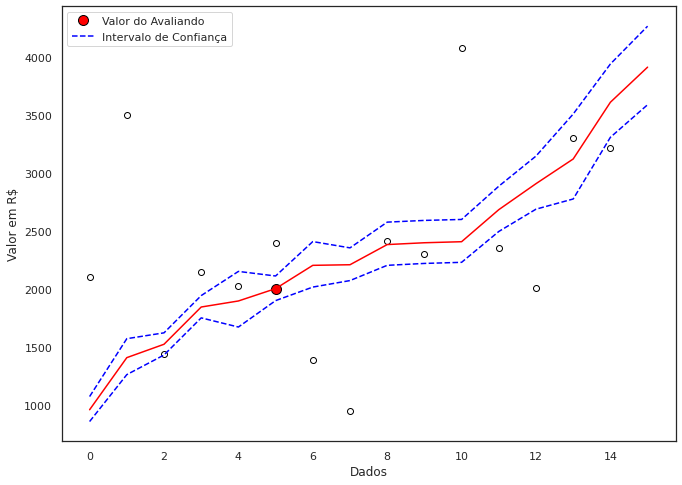

VALORES MÍNIMOS E MÁXIMO NO INTERVALO DE PREDIÇÃO DE 80% 

A amplitude do intervalo de predição é 32.47%
O valor mínimo do intervalo de predição é R$ 1.705,41
O valor máximo do intervalo de predição é R$ 2.356,35
VALORES MÍNIMOS E MÁXIMO NO INTERVALO DE ARBÍTRIO DE 15%
O valor mínimo do campo de arbítrio é R$ 1.703,94
O valor máximo do campo de arbítrio é R$ 2.305,33  
ANÁLISE DE RESÍDUOS E OUTLIERS 
Os resíduos relativos serão, respectivamente

  -0.63%,   1.41%,  -0.78%,  -1.49%,   0.85%,   0.00%,  -0.22%,  -0.10%,  -1.35%,   2.84%,
   0.49%,  -0.17%,  -1.19%,  -1.10%,   1.24%, 

Os resíduos em relação ao desvio da regressão serão, respectivamente:

 -43.25%, 103.66%, -51.09%,-102.90%,  58.19%,   0.22%, -14.03%,  -6.23%, -94.74%, 197.31%,
  36.40%, -11.67%, -81.57%, -80.28%,  89.98%,

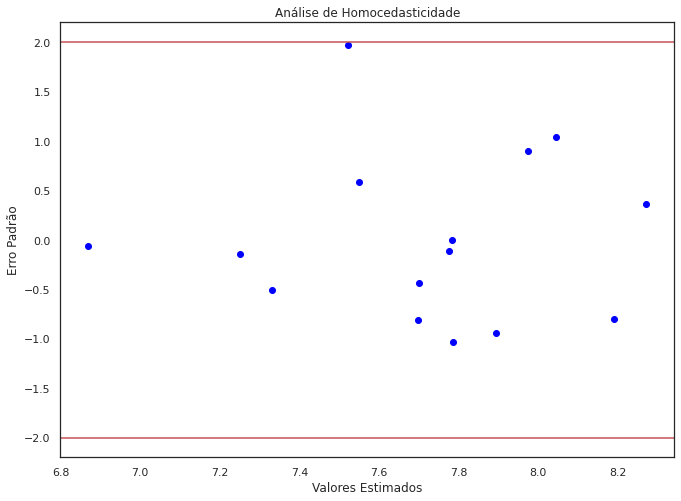

Não existem outliers no modelo
Existem 0.000% % de outliers, valor inferior a 5%
ANÁLISE DO MODELO NÃO LINEAR, COM TRANFORMAÇÃO DE Y


Os resíduos da estimativa não linear serão, respectivamente:

 -44.09%, 161.98%, -35.80%,-110.62%,  53.92%,   0.25%,  -9.28%,  -2.82%,-114.03%, 192.49%,
  68.62%, -13.06%, -81.24%,-130.93%, 130.02%,

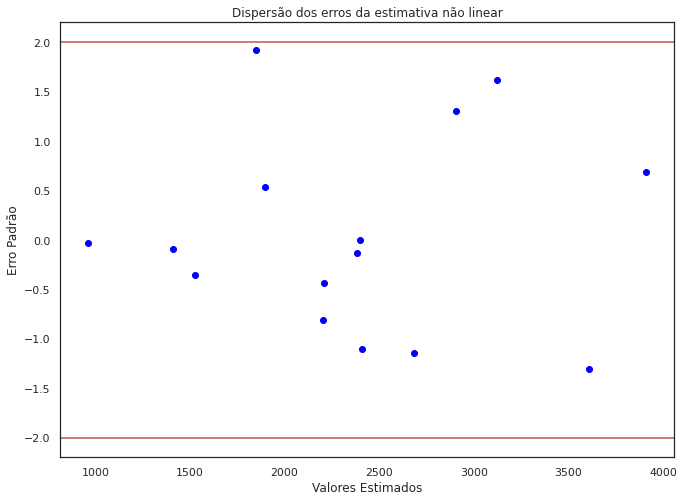

Ao total temos 0 outliers
Os dados  são outliers


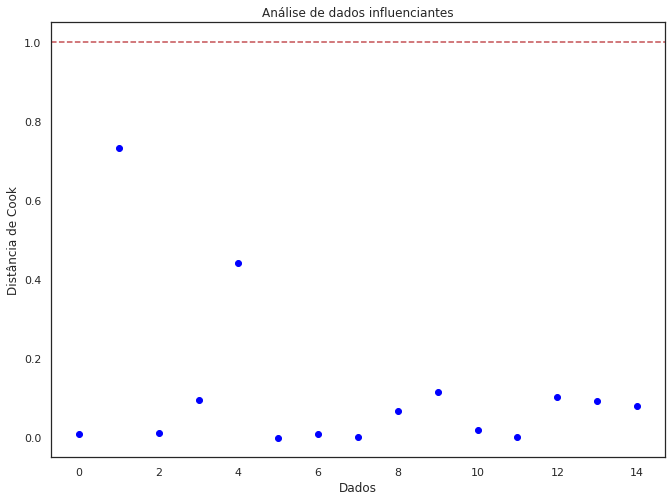

As três maiores distâncias de Cook são 0.7315, 0.4407, 0.1148
Referentes aos seguintes dados: 2, 8, 15
Não existem dados com influência atípica no modelo


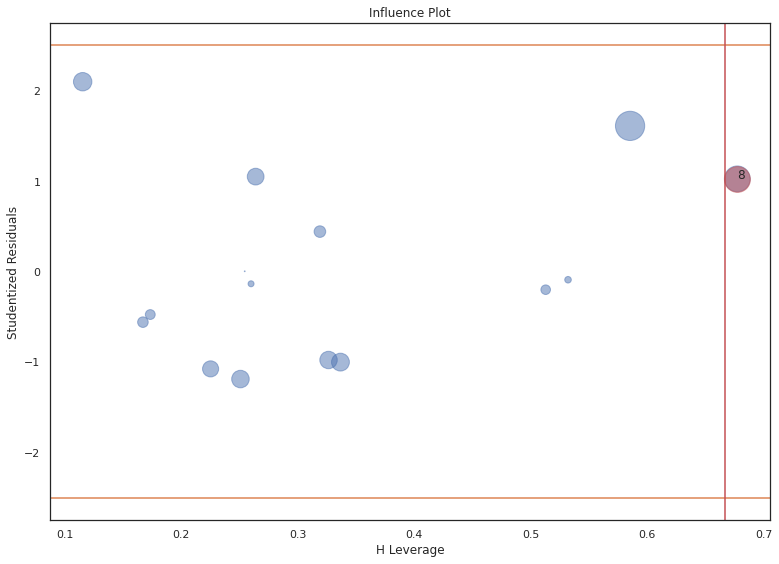

 
TESTE AUTOCORRELAÇÃO DOS ERROS
O teste de Durbin-Watson teve os seguintes valores: dw= 2.330,dl= 0.685, e dh= 1.977
Como (4-dh)<= tdw <(4-dl): Teste Inconclusivo-"Grey Zone"-para dependência entre os resíduos
 
ANÁLISE DE ADERÊNCIA


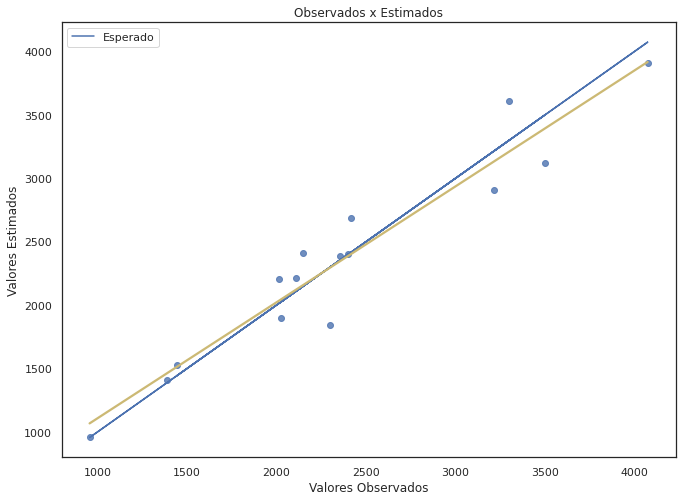

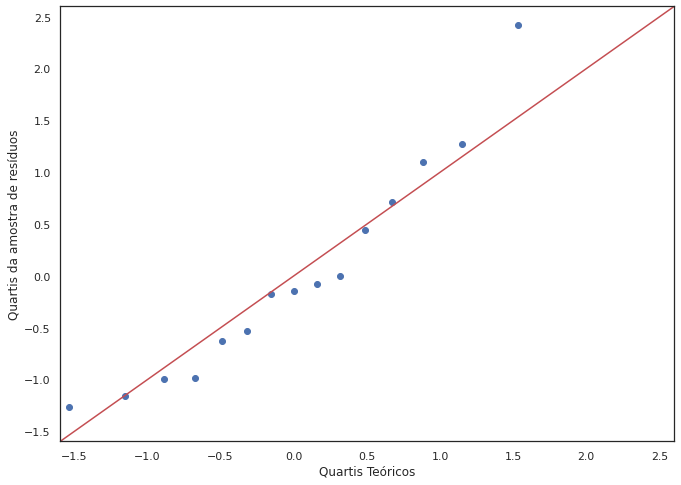

TESTE DE QUI-QUADRADO
Estatística Qui-quadrado: 3.451
p-valor do teste: 48.535%
Amostra semelhante a uma gaussiana (falha em rejeitar H0)
TESTE DE SHAPIRO-WILK
Estatística Shapiro-Wilk: 0.930
p-valor do teste: 27.545%
Amostra semelhante a uma gaussiana (falha em rejeitar H0)
TESTE D’AGOSTINO-PEARSON
Estatística D’Agostino-Pearson: 2.911
p-valor do teste: 23.326%
Amostra semelhante a uma gaussiana (falha em rejeitar H0)
TESTE ANDERSON-DARLING
Estatística Anderson-Darling: 0.360
Significância: 5.000: Valor Crítico: 0.681, Amostra semelhante a uma gaussiana (falha em rejeitar H0)
TESTE KOLMOGOROV-SMIRNOV
Estatística KS: 0.166
p-valor do teste: 74.524%
Amostra semelhante a uma gaussiana (falha em rejeitar H0)
TESTE JARQUE-BERA
Estatística JB:1.609
p-valor do teste:44.727%
Amostra semelhante a uma gaussiana (falha em rejeitar H0)


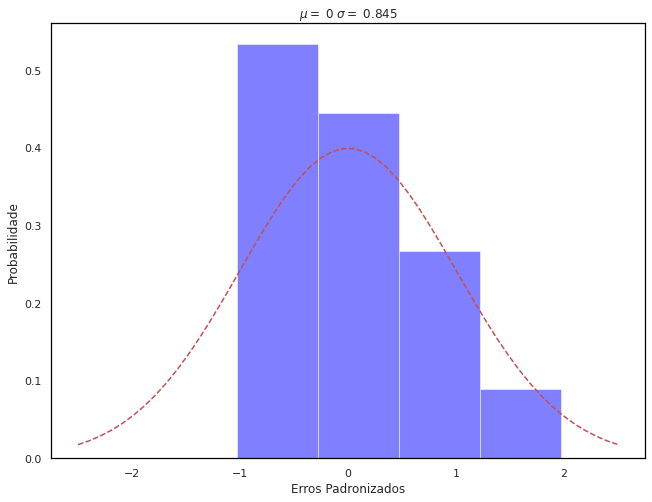

,Intervalo,Curva Normal,Modelo
0,[-1;+1],63 à 73%,80.00%
1,"[-1,64;+1,64]",85 à 95%,93.33%
2,"[-1,96;+1,96]",95 à 100%,93.33%


 
ANALISE DE CORRELAÇÃO ENTRE VARIÁVEIS ISOLADAS  



,LOCALIZAÇÃO,ÁREA LOTE,ESQUINA,DISTÂNCIA,UNITARIO
LOCALIZAÇÃO,1.000000,0.251692,0.037695,-0.269820,0.726014
ÁREA LOTE,0.251692,1.000000,0.146498,-0.259108,-0.088195
ESQUINA,0.037695,0.146498,1.000000,0.261364,0.247629
DISTÂNCIA,-0.269820,-0.259108,0.261364,1.000000,-0.454790
UNITARIO,0.726014,-0.088195,0.247629,-0.454790,1.000000


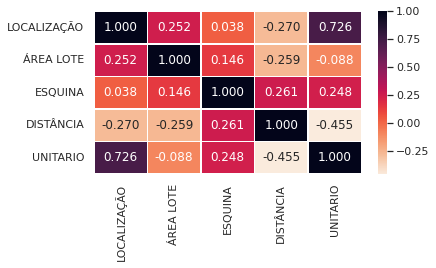

 
ANALISE DE CORRELAÇÃO PARCIAIS COM INFLUÊNCIA 



,LOCALIZAÇÃO,ÁREA LOTE,ESQUINA,DISTÂNCIA,UNITARIO
LOCALIZAÇÃO,-1.000000,0.716031,-0.616324,0.604597,0.873853
ÁREA LOTE,0.716031,-1.000000,0.649056,-0.691629,-0.755813
ESQUINA,-0.616324,0.649056,-1.000000,0.705728,0.733625
DISTÂNCIA,0.604597,-0.691629,0.705728,-1.000000,-0.773286
UNITARIO,0.873853,-0.755813,0.733625,-0.773286,-1.000000


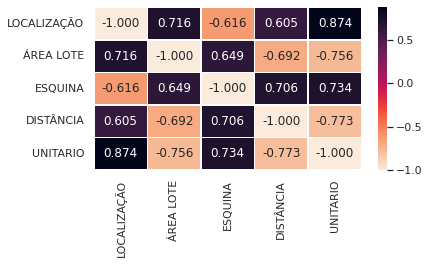

ANALISE DAS VARIÁVEIS MAIS RELEVANTES PARA O MODELO SEGUNDO A ANÁLISE 
DAS COMPONENTES PRINCIPAIS - PCA
O autovalores que representam a variancia são: [1.52587655 1.18934662 0.74435402 0.54042281]
O autovalores que representam a variancia em porcentagem são: [0.38146914 0.29733665 0.18608851 0.1351057 ]
Os autovetores das direções principai 
 [[ 0.56506658  0.1780212   0.78089353  0.198024  ]
 [ 0.54076122  0.39134977 -0.59428139  0.44861152]
 [-0.11337542  0.8296909   0.03127496 -0.54569304]
 [-0.61271778  0.35604328  0.18988628  0.67952432]]

A correlação das variáveis com as direções principais


,CP0,CP1,CP2,CP3
LOCALIZAÇÃO,0.698006,0.194145,0.673723,0.145574
ÁREA LOTE,0.667983,0.426795,-0.512722,0.329790
ESQUINA,-0.140049,0.904837,0.026983,-0.401158
DISTÂNCIA,-0.756868,0.388291,0.163826,0.499542


 
Apenas as variáveis:
ESQUINA
Tem relevância e boa correlação nas direções principais


In [25]:
#@title APÓS O FILTRO ACIMA, ESCOLHA O MODELO MAIS ADEQUADO AOS CRITÉRIOS DE AVALIAÇÃO

modesc = int(
    input(
        '''Escolha na segunda coluna das tabelas acima o modelo que considerar 
mais adequado escrevendo aqui o 'Nºdo Modelo': ''')
    )


posicao = list(id1).index(modesc)
vetor_modescolha = modf2[posicao]


dict_modesc = lst_modelos2[posicao]
b = dict_modesc['b']

print("O Vetor dos coeficientes regressores é",b)
      
# Dicionário das tranformações da variável dependente
dcty = {-2.0:'(1/y**2)=',-1.0:'1/y=',-0.5:'1/sqrt(y)=',
        0:'log(y)=',0.5:'sqrt(y)=',1.0:'y=',2.0:'y**2='}

y_eqest = dcty.get(vetor_modescolha[-1], f'y**{vetor_modescolha[-1]:.3f}=')

# Começa com uma string vazia que acompanha a constante
t_est = [""]
for k in range(npar-1):
    lbd2 = vetor_modescolha[k]
    if lbd2 in dcty:
        strx = dcty[lbd2].replace('=','').replace("y","x" + str(k+1))
    else:
        strx = f'x{k+1}**{lbd2:.3f}'
    t_est.append('*' + strx)

# Concatenando os coeficientes com as variaveis
t_est.append("")       
zs = [f'{k:+.3f}{j}' for k,j in zip(b,t_est)] 
k_est = "".join(zs)

# Juntando o lado direito com o esquerdo da equação
m_est = y_eqest + k_est


eqe = Eq(*map(S, m_est.split('=', 1)))
print(BOLD+f"{RED}A equação da estimativa será")
display(eqe)

R2E = df_stat2.loc[modesc,'R2_est']

if R2E < 0.6:
    r2Ev=', valor muito baixo'
elif (0.6 <= R2E) and (R2E < 0.8):
    r2Ev=', valor aceitável'
elif (0.8<= R2E) and (R2E < 0.9):
    r2Ev=', valor Bom'
else:
    r2Ev=', valor Ótimo'

print(f"{DEFOUT}\nO coeficiente de determinação da Estimativa é R²={R2E:.3f}{r2Ev}"+'\n')

r2 = dict_modesc['r2']

if r2 < 0.6:
    r2v=', valor muito baixo'
elif (0.6 <= r2) and (r2 < 0.8):
    r2v=', valor aceitável'
elif (0.8 <= r2) and (r2 < 0.9):
    r2v=', valor Bom'
else:
    r2v=', valor Ótimo'

print(f"O coeficiente de determinação da regressão é R²={r2:.3f}{r2v}.\n")

# npar = Número de Variáveis independetes + 1
gle = ndados - npar

print(gle,"Graus de Liberdade do Erro \n")

print(ndados-1,"Graus de Liberdade da Regressão \n")

print(f"O coeficiente de determinação da Estimativa ajustado é Ra²= {1-(1-R2E)*(ndados-1)/gle:.3f}",BOLD)
print(f"O coeficiente de determinação da regressão ajustado é Ra²= {1-(1-r2)*(ndados-1)/gle:.3f}",BOLD)

# y estimado pelo modelo
yest = yest_list[posicao]
r = np.corrcoef(yest,y)[1,0]

if r == 0:
    rv=', correlação nula'
elif (r > 0) and (r <= 0.3):
    rv=', correlação fraca'
elif (r > 0.3) and (r <= 0.7):
    rv=', correlação Média'
elif (r > 0.7) and (r <= 0.9):
    rv=', correlação Forte'
elif (r > 0.9) and (r < 1):
    rv=', correlação Fortíssima'
else:
    rv=', correlação perfeita';

print(f"O coeficiente de correlação da regressão é R={r:.3f}{rv}.\n")

# Erro padrão de regressão raiz(MSE) = raiz(SQE/n-k)
Se = dict_modesc['Se']
print(f"O desvio padrão da regressão é Se = {Se:.4f}\n")

print(RED+"TESTE DE HIPÓTESE DOS REGRESSORES"+RED)

sig = dict_modesc['sig']

sg = [f'{sig[i]:.2%}' for i in range(npar)]

print(f"{DEFOUT}As significâncias dos regressores são, respectivamente",sg,BOLD)

sgf = np.array(sig) < 0.1

if all(sgf):
    t0 = "Todos os regressores são significantes:"
    t1 = ""
elif sum(sgf) == 1:
    t0 = "Apenas o regressor de:"
    t1 = 'é significante'
else:
    t0 = "Apenas os regressores de:"
    t1 = 'são significantes';
 
coef = np.array(["constante"] + list(df2.columns[1:-1]))

vsig = ", ".join(coef[sgf])
print(t0,vsig,t1)

psig = max(sig[1:])
print(f"A pior significância do modelo é {psig:.2%} do regressor da variável: {coef[sig.index(psig)]}")

print(RED+"TESTE DE HIPÓTESE DA REGRESSÃO"+RED)

sigF = dict_modesc['sigF']
F = dict_modesc['F']

if sigF < 0.01:
    t5 = "com significância F boa e menor que 1%"
else:
    t5 = "com significância F ruim e maior que 1%"

print(f"{DEFOUT}O valor de F de Fisher-Snedecor é F= {F:.3f} {t5}, Significância ={sigF:.4%}")

VavE = df_stat2.loc[modesc,'VaV_est']
VEMin = min(df_stat2.loc[modesc,['Vmin_est','Vmax_est']])
VEMax = max(df_stat2.loc[modesc,['Vmin_est','Vmax_est']])
ampl = df_stat2.loc[modesc,'Amp_est']

txtvav = usd2rls(VavE)
print(f"{BOLD}O valor estimado do imóvel pelo modelo é R$ {txtvav}")


print(f"{RED}VALORES MÍNIMOS E MÁXIMO NO INTERVALO DE CONFIANÇA DE 80%")

txtVEMin = f"{VEMin:,.2f}"
txtVEMin = txtVEMin.replace(",","@").replace(".",",").replace("@",".")
print(f"{DEFOUT}O valor mínimo estimado do imóvel pelo modelo é R$ {txtVEMin}")

txtVEMax = f"{VEMax:,.2f}"
txtVEMax = txtVEMax.replace(",","@").replace(".",",").replace("@",".")
print(f"O valor máximo estimado do imóvel pela regressão é R$ {txtVEMax}")

print(f"A amplitude do intervalo de confiança da estimativa é {ampl:.2%}")

###############################################################
# GRÁFICO DOS INTERVALOS DE CONFIANÇA DE 80%

# Valores observados transformados
# lst_dd tem correspondencia com o modf
# logo a modesc é seu índice

dd_modesc = lst_dd[modesc]
ymudada = dd_modesc[:,-1].copy()
xmudada = lst_modelos[modesc]['x']

model = sm.OLS(ymudada, xmudada)
model = model.fit()

X_ic = xmudada.copy()

# X do avaliando tranformado adicionando 1 na primeira coluna
X_av1 = np.hstack([1.0,lst_av[modesc]]).astype(float)

# Adicionando o X_av1 na ultima linha
X_ic = np.vstack([X_ic, X_av1])

result = model.get_prediction(X_ic)
res_ci = result.conf_int(alpha = 0.2)

pm_est = np.array([(res_ci[:,0] + res_ci[:,1])/2]).T

bandas = np.hstack((res_ci,pm_est)) # Y estima da regressão linearizada

finvT = invtrans(vetor_modescolha[-1])
try:
    bandasE = finvT(bandas)
except:
    bandasE = np.zeros_like(bandas)
    print("Erro na transformada inversa do gráfico de Intervalo de Confiança")

# Ordenando o array pela ultima coluna
bandas_ord = bandasE[bandasE[:, -1].argsort()]
plt.figure(num = 2, figsize=(11, 8))
plt.plot(range(len(x)), y, linestyle = "None", marker = "o",
         markerfacecolor = "None", color = "black")

#Marcando o valor do avaliando em vermelho
plt.plot(np.where(bandas_ord == bandasE[-1])[0][0], 
         bandasE[-1][-1], linestyle = "None", marker = "o",
         markerfacecolor = "red", color = "red",
         mec = 'black',ms = 10, label="Valor do Avaliando")

plt.plot(range(len(x)+1), bandas_ord[:,2], color = "red")
plt.plot(range(len(x)+1), bandas_ord[:,0], color = "blue", 
         linestyle = "--", label = 'Intervalo de Confiança')
plt.plot(range(len(x)+1), bandas_ord[:,1], color = "blue", linestyle = "--")
plt.xlabel("Dados")
plt.ylabel("Valor em R$")
plt.legend(loc="best")
plt.show()

###############################################################

print("VALORES MÍNIMOS E MÁXIMO NO INTERVALO DE PREDIÇÃO DE 80% ")
# Valor do p-valor para o qual a probabilidade seja menor que 80% bicaudal.
t6 = stats.t.ppf(0.9,df=gle)

Ve = dict_modesc['Ve']
Se = dict_modesc['Se']

sip = t6*np.sqrt(Ve+Se**2)

vav = dict_modesc['vav']

vminp = vav - sip
vmaxp = vav + sip

try:
    maxminp = finvT(np.array([vminp,vmaxp]))
except:
    maxminp = np.zeros(2)
    print("Erro na transformada inrversa do intervalo de predição")
    
ampip = abs((maxminp[1]-maxminp[0]))/VavE

print(f"\nA amplitude do intervalo de predição é {ampip:.2%}")

txtvminpE = usd2rls(min(maxminp))
print(f"O valor mínimo do intervalo de predição é R$ {txtvminpE}")

txtvmaxpE = usd2rls(max(maxminp))
print(f"O valor máximo do intervalo de predição é R$ {txtvmaxpE}")

print(f"{RED}{BOLD}VALORES MÍNIMOS E MÁXIMO NO INTERVALO DE ARBÍTRIO DE 15%")
t_min_ar = usd2rls(VavE*0.85) 
print(f"{DEFOUT}O valor mínimo do campo de arbítrio é R$ {t_min_ar}")

t_max_ar = usd2rls(VavE*1.15)
print(f"O valor máximo do campo de arbítrio é R$ {t_max_ar}",
      RED,BOLD)

print("ANÁLISE DE RESÍDUOS E OUTLIERS ")

# Valores previstos da regressão
yreg = dict_modesc['yreg']

#Resíduos da regressão linearizada
res = ymudada - yreg

#Resíduo relativo aos dados
rrel = res / ymudada

print(f"{BOLD}{DEFOUT}Os resíduos relativos serão, respectivamente")
# Quebrando a linha a cada 10 elementos para melhor visualização
for i,k in enumerate(rrel):
    if i%10 == 0:
        print("")
    print(f"{k:.2%},".rjust(9, " "),end="")

# Resíduo em função do desvio da regressão - Resíduo padronizado
# Resíduos Studentizados
rdp = res / Se
print(BOLD,'\n')
print("Os resíduos em relação ao desvio da regressão serão, respectivamente:")
# Quebrando a linha a cada 10 elementos para melhor visualização
for i,k in enumerate(rdp):
    if i%10 == 0:
        print("")
    print(DEFOUT if abs(k) <= 2 else RED,end="")
    print(f"{k:.2%},".rjust(9, " "),end="")

otl = abs(rdp) > 2

plt.rcParams['figure.figsize'] = (11,8)  
for xn, yn in zip(yreg, rdp):
    color = 'blue'  # Azul para normal
    if abs(yn) >= 2:  # Condição para ser outlier
        color = 'red'  # cor do outlier
    plt.scatter(xn, yn, color=color)

plt.axhline(y = 2, color='r', ls = '-')
plt.axhline(y = -2, color='r', ls = '-')
plt.xlabel('Valores Estimados')
plt.ylabel('Erro Padrão')
plt.title('Análise de Homocedasticidade')
plt.show()

if sum(otl) == 1:
    print("\nApenas um dado é outlier")
    print('O dado',dados[otl][0],'é outlier')
elif sum(otl) > 1:
    print("Ao total temos",sum(otl),"outliers")
    print('Os dados',", ".join( str(k) for k in dados[otl].round(2) ),'são outliers')
else:
    print("Não existem outliers no modelo")

########
if (sum(otl)/ndados) > 0.05:
    print(f"Atenção!! Existem {(sum(otl)/ndados):.3%} % de outliers, valor superior a 5%")

elif (sum(otl)/ndados) == 0.05:
    print(f"Existem {(sum(otl)/ndados):.3%} % de outliers, valor igual a 5%");
else:
    print(f"Existem {(sum(otl)/ndados):.3%} % de outliers, valor inferior a 5%");

###################################

if vetor_modescolha[-1] != 1.0:
    print(f"{RED}{BOLD}ANÁLISE DO MODELO NÃO LINEAR, COM TRANFORMAÇÃO DE Y")

    # Resíduo não linear padronizado

    rdpnl = y - yest
    rdpnl = rdpnl / np.std(rdpnl,ddof=1)

    print(f"{BOLD}{DEFOUT}\n\nOs resíduos da estimativa não linear serão, respectivamente:")
    # Quebrando a linha a cada 10 elementos para melhor visualização
    for i,k in enumerate(rdpnl):
        if i%10 == 0:
            print("")
        print(DEFOUT if abs(k) <= 2 else RED,end="")
        print(f"{k:.2%},".rjust(9, " "),end="")

    otlnl = abs(rdpnl) > 2

    plt.rcParams['figure.figsize'] = (11,8)  
    for xn, yn in zip(yest, rdpnl):
        color = 'blue'  # Azul para normal
        if abs(yn) >= 2:  # Condição para ser outlier
            color = 'red'  # cor do outlier
        plt.scatter(xn, yn, color=color)

    plt.axhline(y = 2, color='r', ls = '-')
    plt.axhline(y = -2, color='r', ls = '-')
    plt.xlabel('Valores Estimados')
    plt.ylabel('Erro Padrão')
    plt.title('Dispersão dos erros da estimativa não linear')
    plt.show()

    if sum(otlnl) == 1:
        print("\nApenas um dado é outlier")
        print('O dado',dados[otlnl][0],'é outlier')
    else:
        print("Ao total temos",sum(otlnl),"outliers");
        print('Os dados',", ".join([str(k) for k in dados[otlnl].round(2)]),'são outliers');
      
##############################################################

c = dict_modesc['c']
xm = np.array(dict_modesc['x'])

# Matriz Chapeu para identificação dos pontos de alavanca, o posto da martiz = p+1, 
# logo observa-se o valor acima do dobro do média como possivel influenciante.
Hl = xm @ (c @ (xm.T))

msr = dict_modesc['msr']

#Distância de Cook para identificação de dados influenciantes
dck = [ (res[i]**2)*Hl[i][i] / ( npar*msr*((1-Hl[i][i])**2) )  for i in range(ndados)] 

for xc, yc in zip(range(ndados),dck):
    color = 'blue'  # Azul para normal
    if not yc <= 1:  # Condição para ser outlier
        color = 'red'  # vermelho para outlier
    plt.scatter(xc, yc, color=color)

plt.axhline(y = 1,color='r', ls = '--')
plt.xlabel('Dados')
plt.ylabel('Distância de Cook')
plt.title('Análise de dados influenciantes')
plt.show()

dcks = sorted(dck,reverse=True)
tdck = [f'{i:.4f}' for i in dcks[:3]]
print("As três maiores distâncias de Cook são",", ".join(tdck))

dtck = [str(dados[dck.index(k)]) for k in dcks[:3]]
print("Referentes aos seguintes dados:",", ".join(dtck))

outc = [dados[dck.index(i)] for i in dcks if i > 1]

if len(outc) == 0:
    print("Não existem dados com influência atípica no modelo")
elif len(outc) == 1:
    print("O dado "+str(outc)+" tem influência atípica no modelo")
else:
    print("Os dados "+str(outc)+" tem influência atípica no modelo")

# Plotando gráfico de pontos influenciantes 
# Juntando distância de cook, alavancagem e resíduo studentizado
leverage_inf(model)

print(RED,BOLD)
print("TESTE AUTOCORRELAÇÃO DOS ERROS")
dw = [ ((res[i+1]-res[i])**2) for i in range(ndados-1)]

ssr = dict_modesc['ssr']
tdw = sum(dw) / ssr

url = 'https://raw.githubusercontent.com/rafaeldjsm/Engenharia/main/Avaliacao%20de%20Imoveis/DW.csv'
dwdf = pd.read_csv(url) #Importando dados do teste de Durbin-Watson

# Tamanho da amostra para o teste de Durbin-Watson
Tamostra = ndados if ndados >= 6 else 6

dwT = dwdf.loc[(dwdf['T']) == Tamostra]
dwK = dwT.loc[(dwT['K']) == npar]
dl = float((dwK.loc[:'dl']).iloc[0,2].replace(",","."))
dh = float((dwK.loc[:'dl']).iloc[0,3].replace(",","."))

print(f'{DEFOUT}O teste de Durbin-Watson teve os seguintes valores: dw= {tdw:.3f},dl= {dl:.3f}, e dh= {dh:.3f}')

if (0 <= tdw) and (tdw < dl):
    print('Como 0<= tdw < dl: autocorrelação positiva - Há dependência entre os resíduos')
elif (dl <= tdw) and (tdw < dh):
    print('Como dl<= tdw < dh: Teste Inconclusivo-"Grey Zone"-para dependência entre os resíduos')
elif (dh <= tdw) and (tdw <(4-dh)):
    print('Como dh<= tdw <(4-dh):Não há autocorrelação entre os resíduos')
elif ((4-dh)<= tdw) and (tdw <(4-dl)):
    print('Como (4-dh)<= tdw <(4-dl): Teste Inconclusivo-"Grey Zone"-para dependência entre os resíduos')
else:
    print('Como (4-dl)<= tdw <4: Indicador de significativa autocorrelação negativa')

print(RED,BOLD)
print("ANÁLISE DE ADERÊNCIA")

#Gráfico dos valores observados x estimados
plt.rcParams['figure.figsize'] = (11,8)
plt.plot(y,y,'-b',label = "Esperado")
# scatter_plot = plt.scatter(y,yest,alpha=0.5,color = 'b')

#ols  linear_model
dfregy2x = pd.DataFrame({'x': y, 'y': yest})
sns.regplot(x="x", y="y", data = dfregy2x, line_kws={"color": "y"}, ci = None)
plt.xlabel('Valores Observados')
plt.ylabel('Valores Estimados')
plt.title('Observados x Estimados')
plt.legend()
plt.show()

# QQ Plot de Normalidade
fig = qqplot(rdp,line='45',fit='True')
plt.xlabel("Quartis Teóricos")
plt.ylabel("Quartis da amostra de resíduos")
plt.show()

# Test Qui-Quadrado
chisqr(rdp, signf = 0.05)

#Teste Shapiro-Wilk
alpha_n = 0.05
esw, p_a = stats.shapiro(rdp)

print(f'{BOLD}{RED}TESTE DE SHAPIRO-WILK')

print(f'{DEFOUT}Estatística Shapiro-Wilk: {esw:.3f}')
print(f'p-valor do teste: {p_a:.3%}')
if p_a > alpha_n:
  shapiro1='Amostra semelhante a uma gaussiana (falha em rejeitar H0)'
else:
  shapiro1=' Amostra não se assemelha a uma gaussiana  (rejeita H0)'

print(BOLD+shapiro1)

#Teste de D’Agostino-Pearson 
print(f'{BOLD}{RED}TESTE D’AGOSTINO-PEARSON')
warnings.filterwarnings("ignore", message="kurtosistest only valid for n>=20")

if ndados >= 8:
    stat, p2 = stats.normaltest(rdp)
    print(f'{DEFOUT}Estatística D’Agostino-Pearson: {stat:.3f}')
    print(f'p-valor do teste: {p2:.3%}')
    # interpretação
    if p2 > alpha_n:
        print('Amostra semelhante a uma gaussiana (falha em rejeitar H0)')
    else:
        print(' Amostra não se assemelha a uma gaussiana  (rejeita H0)')
else:
    print("Como a amostra é menor que 8, não é possível fazer o teste de D’Agostino-Pearson")

#Teste Anderson-Darling 
print(f'{BOLD}{RED}TESTE ANDERSON-DARLING')
result = stats.anderson(rdp)
st_res = result.statistic
print(f'{DEFOUT}Estatística Anderson-Darling: %.3f' % st_res)

sl, cv = result.significance_level[2], result.critical_values[2]
if st_res < cv:
    print('Significância: %.3f: Valor Crítico: %.3f, Amostra semelhante a uma gaussiana (falha em rejeitar H0)' % (sl, cv))
else:
    print('Significância: %.3f: Valor Crítico: %.3f, Amostra não se assemelha a uma gaussiana  (rejeita H0)' % (sl, cv))

#Teste Kolmogorov-Smirnov
print(f'{BOLD}{RED}TESTE KOLMOGOROV-SMIRNOV')
ks_Estatistica, p_ks = stats.kstest(rdp, 'norm')

print(f'{DEFOUT}Estatística KS: {ks_Estatistica:.3f}')
print(f'p-valor do teste: {p_ks:.3%}')
if p_ks > alpha_n:
  	print('Amostra semelhante a uma gaussiana (falha em rejeitar H0)')
else:
	print(' Amostra não se assemelha a uma gaussiana  (rejeita H0)')

# Jarque-Bera teste
print(BOLD+RED+"TESTE JARQUE-BERA")
sjb, pjb = stats.jarque_bera(rdp)

print(f'{DEFOUT}Estatística JB:{sjb:.3f}')
print(f'p-valor do teste:{pjb:.3%}')

if pjb > alpha_n:
  	print('Amostra semelhante a uma gaussiana (falha em rejeitar H0)')
else:
	print(' Amostra não se assemelha a uma gaussiana  (rejeita H0)')


# Histograma dos residuos padronizados (Studentizados)
xp = np.linspace(-2.5,2.5, 50)

# Adicionando uma distribuição normal
ya = norm.pdf(xp, 0, 1)

# Ajuste do espaçamento para evitar o recorte do rótulo
plt.subplots_adjust(left=0.15)
plt.rcParams.update({'figure.figsize' : (11,8),
                     "axes.facecolor" : "white",
                    "axes.edgecolor": "black"})

plt.hist(rdp, 4, density=1, facecolor='blue', alpha=0.5)
plt.plot(xp, ya, 'r--')
plt.xlabel('Erros Padronizados')
plt.ylabel('Probabilidade')
plt.title(f'$\mu=$ 0 $\sigma=$ {np.std(rdp,ddof=1):.3f}')
plt.show()

nrm1 = [ i for i in rdp if (abs(i) <= 1)]
nrm2 = [ i for i in rdp if (abs(i) <= 1.64)]
nrm3 = [ i for i in rdp if (abs(i) <= 1.96)]

int1 = len(nrm1) / (ndados)
int2 = len(nrm2) / (ndados)
int3 = len(nrm3) / (ndados)

dfnld = pd.DataFrame(
    {'Intervalo':['[-1;+1]', '[-1,64;+1,64]','[-1,96;+1,96]'],
     'Curva Normal':['63 à 73%','85 à 95%','95 à 100%'],
     'Modelo':[int1,int2,int3]})

dfnld.set_index('Intervalo')
dfnldst = dfnld.style.set_properties(**{'text-align': 'center'})                       
dfnldst = dfnld.style.format({'Modelo': '{:,.2%}'.format})
display(dfnldst)

if ( 
    ( (0.63 <= int1) and (int1 <= 0.73) ) and 
    ( (0.85 <= int2) and (int2 <= 0.95) ) and 
    ( (0.95 <= int3) and (int3 <= 1  ) )
    ):
    print('Normalidade conforme a NBR-14.653-2 (A.2.1.2) está aderente')

df3 = df2.iloc[:,1:].corr()

def color_red80p(val):
    color = 'red' if abs(val) > 0.8 else 'black'
    return 'color: %s' % color

print(RED,BOLD)
print(f"ANALISE DE CORRELAÇÃO ENTRE VARIÁVEIS ISOLADAS {BOLD} \n")

s = df3.style.applymap(color_red80p) #Analisar correlações maiores que 80%
display(s)

cmap = sns.cm.rocket_r
fig, ax = plt.subplots(figsize=(6, 3))
fig = sns.heatmap(df3, annot = True, fmt=".3f", linewidths=.6,cmap = cmap)
plt.show()

df3i = np.linalg.inv(df3)
print(RED,BOLD)
print("ANALISE DE CORRELAÇÃO PARCIAIS COM INFLUÊNCIA",'\n')


corp = []
for k in range(npar):
    corp_int = []
    for i in range(npar):
        corp_int.append(-(df3i[i][k])/np.sqrt((df3i[i][i])*(df3i[k][k])))
    corp.append(corp_int)
                    
corp = pd.DataFrame(corp)

corp.columns = df3.columns
corp.index = corp.columns

#Analisar correlações maiores que 80%
sci = corp.style.applymap(color_red80p)
display(sci)



fig, ax = plt.subplots(figsize=(6, 3))
fig = sns.heatmap(corp, annot = True, fmt=".3f", linewidths=.6,cmap = cmap)
plt.show()


print(f'''{BOLD}ANALISE DAS VARIÁVEIS MAIS RELEVANTES PARA O MODELO SEGUNDO A ANÁLISE 
DAS COMPONENTES PRINCIPAIS - PCA''')

# Se a matriz de covariância, Σ, for construída com variáveis padronizadas, é chamada de
# matriz de correlação, R(pxp): 

df6 = df2.corr()
# The eigenvalues are not necessarily ordered
ev1, ev2 = np.linalg.eigh((df6.iloc[1:-1,1:-1])) #Autovalores, Autovetores
idx = np.argsort(ev1)[::-1]
# Ordenando pelos maiores autovalores
ev1 = ev1[idx]
ev2 = ev2[:,idx]

print(f"{DEFOUT}O autovalores que representam a variancia são:",ev1)
ev1p = ev1/sum(ev1)
print("O autovalores que representam a variancia em porcentagem são:",ev1p)

print("Os autovetores das direções principai \n",ev2)


# Somatório de variancias até 80% acumulado
sumav = 0
ndpr = 0
for k in range(npar-1):
    if sumav < 0.8:
        sumav = sumav + ev1p[k]
        ndpr = k+1;

corlvdp=[]
for k in range(npar-1):
    for i in range(npar-1):
        corlvdp.append((ev2[k][i])*np.sqrt(ev1[i]));
corlvdp = np.reshape(corlvdp , (npar-1, npar-1))


corlvdp = pd.DataFrame(corlvdp)

corlvdp.columns = [ 'CP'+str(i) for i in range(npar-1)]
corlvdp.index = df3.columns[:npar-1]

def color_blue80p(val):
    color = 'blue' if abs(val) > 0.8 else 'black'
    return 'color: %s' % color

print(BOLD)
print("A correlação das variáveis com as direções principais")
sdp = corlvdp.style.applymap(color_blue80p) #Analisar correlações maiores que 80% nas direções principais
display(sdp)

varel = np.where(abs(corlvdp.iloc[:,:ndpr])>=0.8)

print(RED,BOLD)
print("Apenas as variáveis:")
for k in varel[0]:
    print(df3.columns[:npar-1][k]);
print("Tem relevância e boa correlação nas direções principais")


In [26]:
rspx = str(input("Deseja fazer a simulação bootstrap :"))

Deseja fazer a simulação bootstrap :sim


In [27]:
df4 = pd.DataFrame(dd_modesc, index = dados, columns = df3.index)
df4

,LOCALIZAÇÃO,ÁREA LOTE,ESQUINA,DISTÂNCIA,UNITARIO
1,31.622777,0.001620,0.0,0.000000,7.652682
2,29.154759,0.001946,1.0,0.000000,8.161074
4,30.000000,0.001802,0.0,0.693147,7.273399
5,34.641016,0.001342,0.0,0.000000,7.672130
8,34.641016,0.001157,1.0,1.098612,7.613554
9,34.641016,0.001333,0.0,0.000000,7.783224
10,23.452079,0.001852,0.0,0.000000,7.236259
11,24.494897,0.002389,0.0,1.386294,6.862543
14,34.641016,0.002415,0.0,0.693147,7.789645
15,31.622777,0.002000,0.0,0.693147,7.740664


In [28]:
#@title RESUMO DA REGRESSÃO

print(model.summary(alpha=0.2))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     38.36
Date:                Tue, 16 Aug 2022   Prob (F-statistic):           4.88e-06
Time:                        12:57:37   Log-Likelihood:                 14.684
No. Observations:                  15   AIC:                            -19.37
Df Residuals:                      10   BIC:                            -15.83
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|        [0.1        0.9]
------------------------------------------------------------------------------
const          4.9169      0.295     16.657      0.0

#Estimativa de Preço Médio por Reamostragem Bootstrap
O método bootstrap, introduzido por Efron (1979), é um método de reamostragem
baseado na construção de subamostras a partir de uma amostra inicial (também denotada de amostra mestre) de tamanho $n$ finito. A reamostragem consiste em sortear com reposição dados pertencentes a uma amostra retirada anteriormente (amostra mestre), de modo a formar uma nova amostra. Observe que a reamostragem não adiciona nenhuma informação nova à amostra original.

A ideia do bootstrap é empregar, por exemplo,as médias das reamostras para estimar como a média amostral de uma amostra de tamanho $n$, extraída dessa população, varia em decorrência da amostragem aleatória.

Existem basicamente duas maneiras de se realizar o bootstrap: não-paramétrica
e paramétrica. O bootstrap não-paramétrico considera que a função de distribuição dos dados ℱ é desconhecida e pode ser estimada pela distribuição empírica $\hatℱ$.

Já o bootstrap paramétrico considera que a função de distribuição ℱ pode ser estimada por $\hatℱ$ a partir de um modelo paramétrico conhecido para os dados.

Como o bootstrap não-paramétrico não depende da distribuição que os
dados seguem (distribuição desconhecida), o mesmo pode ser utilizado para qualquer conjunto de dados, tendo então maior aplicabilidade do que o bootstrap paramétrico.

#Agora obteremos e Analisaremos a distribuição empirica da média obtida e seu intervalo de Confiança

##Itervalo de Confiança Percentil
Para o calculo do intervalo de confiança pelo percentil bootstrap formado pelos intervalos  $\frac{α}2$ e $1−\frac{α}2$ percentual da distribuição $θ$ obtida pela reamostragem, onde θ representa a parametro de interesse e α é o nível de segurança <br>
(Ex:., α = 0.05 para 95% de Intervalo de Confiança)


$$
[\hat{θ}_{limite Inferior},\hat{θ}_{limite superior}]=[\hatθ^{\ast }_j, \hatθ^{\ast }_k]
$$


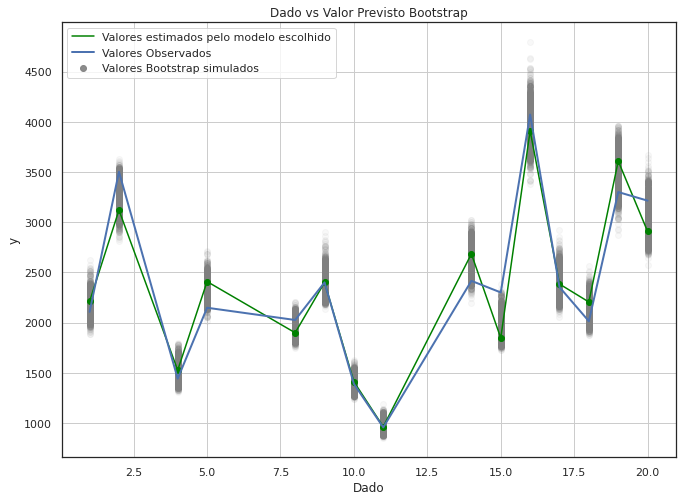

In [53]:
#@title REAMOSTRAGEM BOOTSTRAP

# resample with replacement each row

boot_slope1 = []
boot_interc = []
y_pred_lst = []
boot_r2 = []
n_boots = 5000

sns.set(style="white")
plt.figure(figsize=(11, 8))

for k in range(n_boots):
    # sample the rows, same size, with replacement
    sample_df = df4.sample(n = ndados, replace=True, random_state = k)
    # fit a linear regression
    xboot = sample_df.iloc[:,:-1].copy(deep = True).values
    xboot = sm.add_constant(xboot)
    yboot = sample_df.iloc[:,-1].copy(deep=True)
    ols_model_temp = sm.OLS(yboot,xboot)
    results_temp = ols_model_temp.fit()

    # append coefficients
    boot_interc.append(results_temp.params[0])
    if len(results_temp.params) > 1:
        boot_slope1.append(results_temp.params[1:])

    boot_r2.append(results_temp.rsquared)

    dds = sample_df.index

    try:
        y_pred_lst.append(finvT(results_temp.predict(X_av1)[0]))
        y_pred_temp = finvT(results_temp.fittedvalues)
        # OBSERVAÇÃO DO INTERVALO DE CONFIANÇA DE CADA DADO (REG MULTIVARIADA)
        plt.scatter(dds,y_pred_temp, color='grey', alpha=0.05)
    except:
        pass
plt.scatter(dds,y_pred_temp, color='grey', alpha=0.9, 
            label = 'Valores Bootstrap simulados')

plt.scatter(dados, yest, color = 'green')
            
plt.plot(dados, yest, color = 'green',
         label = 'Valores estimados pelo modelo escolhido')
plt.plot(dados, y, linewidth = 2, label = 'Valores Observados')
plt.grid(True)
plt.xlabel('Dado')
plt.ylabel('y')
plt.title('Dado vs Valor Previsto Bootstrap')
plt.legend(loc="upper left")
plt.show()

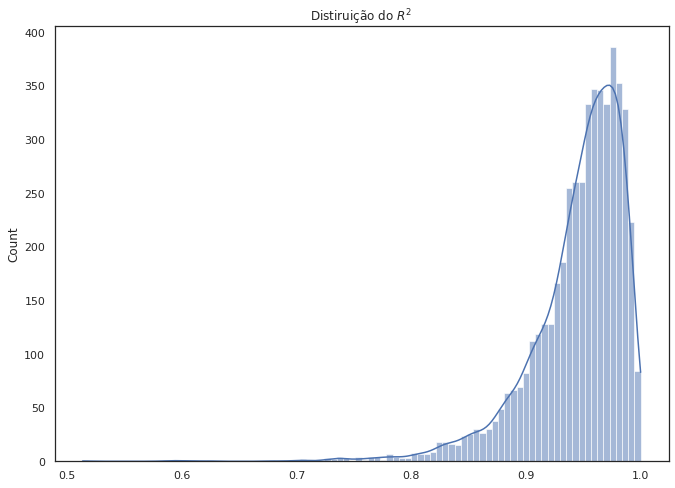

In [54]:
#@title DISTRIBUIÇÃO DO R²
plt.title('Distiruição do $R^2$')
sns.histplot(boot_r2, kde = True);

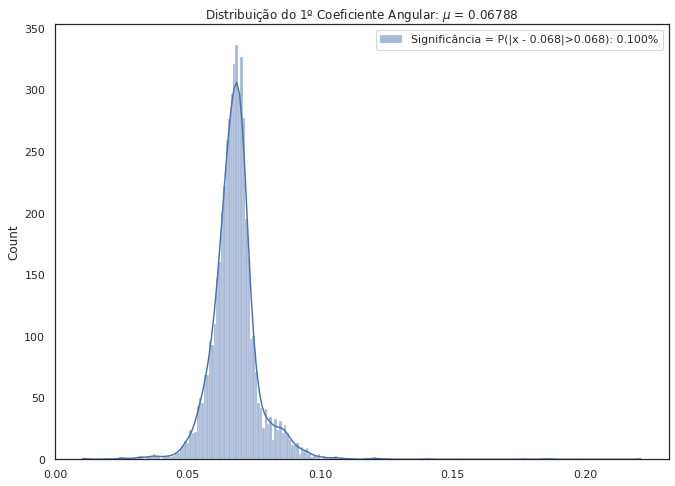

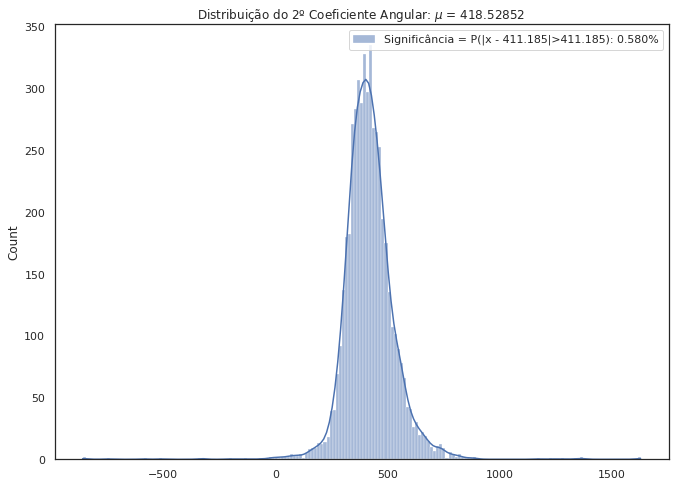

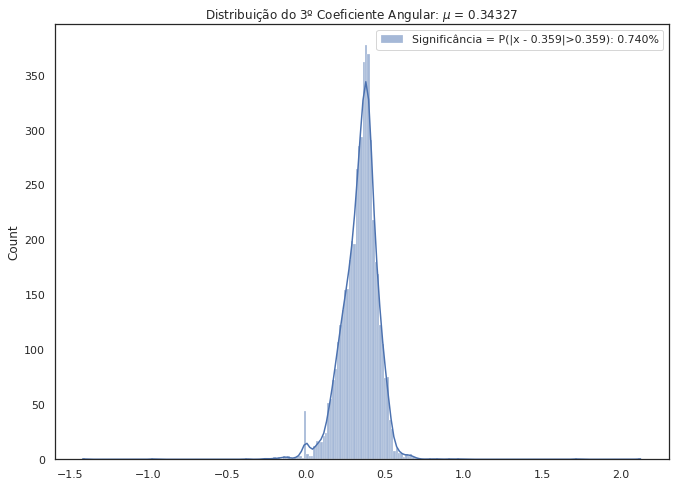

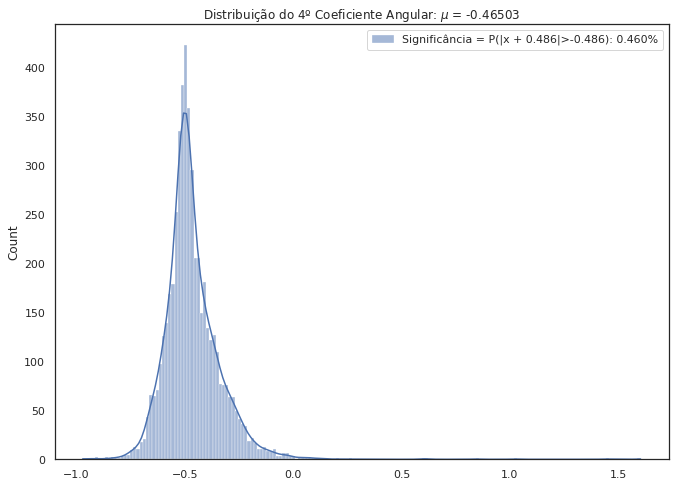

In [55]:
#@title SIGINIFICÂNCIA DO COEFICIENTE ANGULAR

boot_slope1 = np.array(boot_slope1)
nv = len(b)

for k in range(nv-1):

    # Significância Beta 1
    pic = 0.9

    boot_slopes_ar = boot_slope1[:,k]

    mb1 = 2 * np.median(boot_slopes_ar)

    if mb1 > 0:
        sigb1 = (len(boot_slopes_ar[(boot_slopes_ar<0) | (boot_slopes_ar > mb1) ]) / n_boots)
        tstmb1 = f'Significância = P(|x - {mb1/2:.3f}|>{mb1/2:.3f}): {sigb1:.3%}'
    else:
        sigb1 = (len(boot_slopes_ar[(boot_slopes_ar>0) | (boot_slopes_ar < mb1) ]) / n_boots)
        tstmb1 = f'Significância = P(|x + {-mb1/2:.3f}|>{mb1/2:.3f}): {sigb1:.3%}'

    plt.title(f'Distribuição do {k+1}º Coeficiente Angular: $\mu$ = {boot_slopes_ar.mean():.5f}')
    sns.histplot(boot_slopes_ar, kde = True, label = tstmb1);
    plt.legend(loc = 'upper right')
    plt.show()

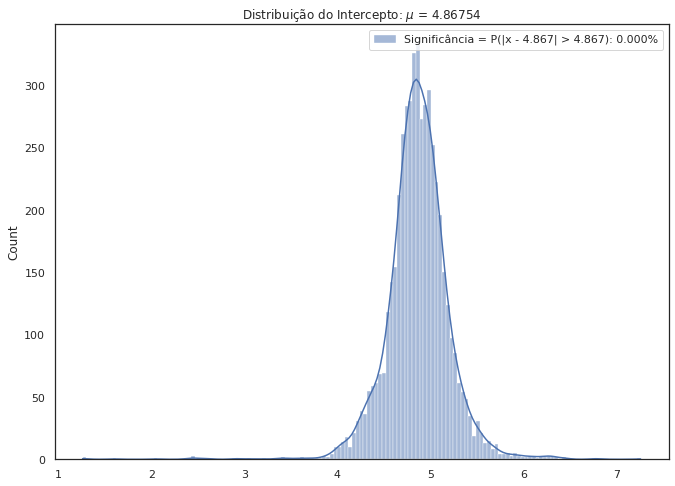

In [56]:
#@title SIGNIFICÂNCIA DO INTERCEPTO

# get cumulative probability for values

# Significância Beta 0 

mb0 = 2 * np.median(boot_interc)

boot_interc_ar = np.array(boot_interc)

if mb0 >= 0:
    sigb0 = (len(boot_interc_ar[(boot_interc_ar<0) | (boot_interc_ar > mb0) ]) / n_boots)
    tstmb0 = f'Significância = P(|x - {mb0/2:.3f}| > {mb0/2:.3f}): {sigb0:.3%}'
else:
    sigb0 = (len(boot_interc_ar[(boot_interc_ar>0) | (boot_interc_ar < mb0) ]) / n_boots)
    tstmb0 = f'Significância = P(|x + {-mb0/2:.3f}| > {mb0/2:.3f}): {sigb0:.3%}'



sns.histplot(boot_interc, legend = True,kde=True, label = tstmb0); #stat="density"
plt.title(f'Distribuição do Intercepto: $\mu$ = {boot_interc_ar.mean():.5f}')
plt.legend(loc = 'upper right')
plt.show()

#Agora obteremos e Analisaremos a distribuição empirica da média obtida e seu intervalo de Confiança

##Itervalo de Confiança Percentil
Para o calculo do intervalo de confiança pelo percentil bootstrap formado pelos intervalos  $\frac{α}2$ e $1−\frac{α}2$ percentual da distribuição $θ$ obtida pela reamostragem, onde θ representa a parametro de interesse e α é o nível de segurança <br>
(Ex:., α = 0.05 para 95% de Intervalo de Confiança)


$$
[\hat{θ}_{limite Inferior},\hat{θ}_{limite superior}]=[\hatθ^{\ast }_j, \hatθ^{\ast }_k]
$$


Mediana da Distribuição Empírica 2017.321


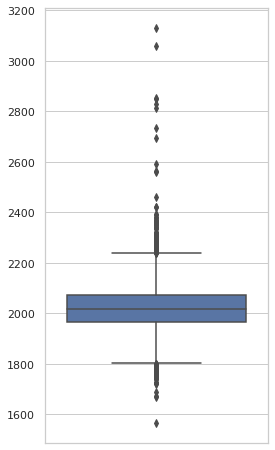

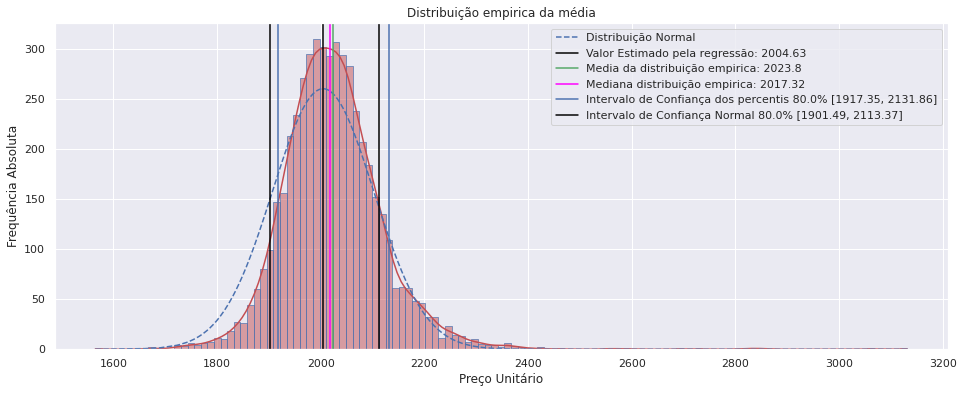

In [57]:
#@title Execute esta célula para executar a análise de Reamostragem Bootstrap da média.

# Retirando valores Nan
y_pred_lst = [x for x in y_pred_lst if str(x) != 'nan']

Q1b, Mediana_B, Q3b = np.quantile(y_pred_lst, [0.25,0.5,0.75])
Media_B = np.mean(y_pred_lst)

p = 0.8 #80% de intervalo de confiança
print( f'Mediana da Distribuição Empírica {Mediana_B:.3f}')

# Box Plot
plt.figure(figsize=(4, 8))
sns.set(style="whitegrid")
ax = sns.boxplot(y=y_pred_lst)

# Histograma
sns.set(style="darkgrid")
plt.figure(figsize=(16, 6))
sns.histplot(y_pred_lst, color='r', kde = True, edgecolor="b", 
             linewidth=.675)


f_obs, bins = np.histogram(y_pred_lst, bins = 'auto')
largura_col = bins[1]-bins[0]

xp = sorted(y_pred_lst)
sigma = np.std(y_pred_lst, ddof = 1)

# Adicionando uma curva distribuição normal
ya = norm.pdf(xp, VavE, sigma)*largura_col*n_boots
plt.plot(xp, ya, 'b--', label="Distribuição Normal")
plt.xlabel("Preço Unitário")
plt.ylabel("Frequência Absoluta")
plt.title("Distribuição empirica da média")

# Linha Vertical do Valor Estimado pela regressão
plt.axvline(x = VavE,color='black', label = "Valor Estimado pela regressão: {}"
.format(np.round(VavE,2))) 

# Linha Vertical da Média da distriuição empirica
plt.axvline(x = Media_B,color='g', label = "Media da distribuição empirica: {}"
.format(np.round(Media_B,2))) 

# Linha Vertical da Mediana da distriuição empirica
plt.axvline(x = Mediana_B,color='magenta', label="Mediana distribuição empirica: {}"
.format(np.round(Mediana_B,2))) 

ici, ics = np.quantile(y_pred_lst, [(1- p)/2,(1+p)/2])

# Linha Vertical do intervalor de confiança percentil da distribuição empirica
plt.axvline(x = ici, color = 'b', 
            label = "Intervalo de Confiança dos percentis {}% ".format(p*100)+"{}"
            .format(np.round([ici, ics],2).tolist())) 
plt.axvline(x = ics,color='b') 

# Linha Vertical do intervalor de confiança percentil da distribuição normal
plt.axvline(x = VEMin, color = 'black', 
            label = "Intervalo de Confiança Normal {}% ".format(p*100)+"{}"
            .format(np.round([VEMin, VEMax],2).tolist())) 
plt.axvline(x = VEMax, color = 'black')

plt.legend(loc = 'best')
plt.show()

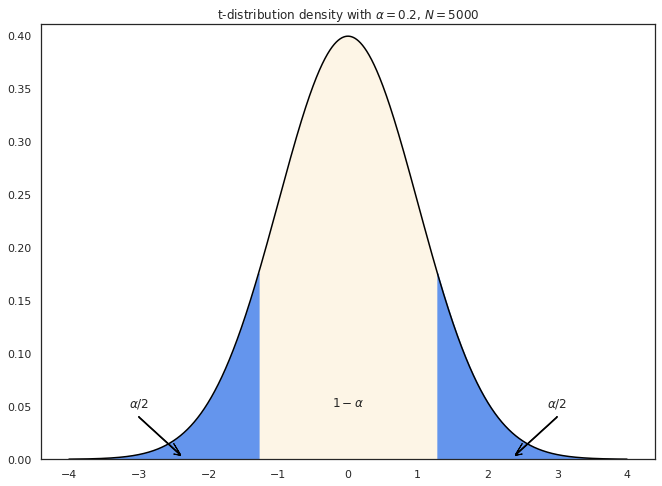

In [58]:
#@title EXEMPLO DO IC NA DISTRIBUIÇÃO t

sns.set(style="white")

N = n_boots
alpha = 0.2
xt = np.linspace(start = -4, stop = 4, num = int(1e5))
hx = stats.t.pdf(xt, df = N - 2)
# Get the critical values for the specified probability:
crit_vals = stats.t.ppf(q = alpha / 2, df = N-2)
# Plot the density
_ = plt.figure(num = 1, figsize=(11, 8))
_ = plt.plot(xt, hx, color = "black")
_ = plt.margins(y = 0)
_ = plt.ylim((0, 0.41))
# Shade in the relevant parts of the density
_ = plt.fill_between(xt[np.logical_and(xt >= crit_vals, xt <= -crit_vals)], 
                 hx[np.logical_and(xt >= crit_vals, xt <= -crit_vals)], 
                 color = "oldlace")
_ = plt.fill_between(xt[xt <= crit_vals], hx[xt <= crit_vals], color = "cornflowerblue")
_ = plt.fill_between(xt[xt >= -crit_vals], hx[xt >= -crit_vals], color = "cornflowerblue")
#
_ = plt.title(f"t-distribution density with $\\alpha = {alpha}$, $N={N}$")
#
_ = plt.text(0, 0.05, '$1-\\alpha$', fontsize = 12, ha = "center")
_ = plt.text(-3, 0.05, '$\\alpha/2$', fontsize = 12, ha = "center")
_ = plt.text(3, 0.05, '$\\alpha/2$', fontsize = 12, ha = "center")
_ = plt.arrow(-3, 0.04, -2.5-(-3), 0.01 - 0.04, color = "black", 
          head_width=0.01, head_length=0.1, overhang = 1)
_ = plt.arrow(3, 0.04, 2.5-3, 0.01 - 0.04, color = "black", 
          head_width=0.01, head_length=0.1, overhang = 1)
plt.show()

In [59]:
#@title VALORES ESTIMADOS PELO MÉTODO BOOSTSTRAP

txtvav = usd2rls(Mediana_B)
print(f"{BOLD}O valor estimado do imóvel é de R$ {txtvav}")


print(f"{RED}VALORES MÍNIMOS E MÁXIMO NO INTERVALO DE CONFIANÇA DE 80% BOOTSTRAP")

txtVEMin = usd2rls(ici)
print(f"{DEFOUT}O valor mínimo estimado do imóvel é R$ {txtVEMin}")

txtVEMax = usd2rls(ics)
print(f"{DEFOUT}O valor máximo estimado do imóvel é R$ {txtVEMax}")

print(f"A amplitude do intervalo de confiança da estimativa é {(ics-ici)/Mediana_B:.2%}")

O valor estimado do imóvel é de R$ 2.017,32
VALORES MÍNIMOS E MÁXIMO NO INTERVALO DE CONFIANÇA DE 80% BOOTSTRAP
O valor mínimo estimado do imóvel é R$ 1.917,35
O valor máximo estimado do imóvel é R$ 2.131,86
A amplitude do intervalo de confiança da estimativa é 10.63%


#TESTES DE NORMALIDADE DA REAMOSTRAGEM BOOTSTRAP

TESTE DE SHAPIRO-WILK
Estatistica Shapiro-Wilk : 0.9261627197265625 
 p-valor do teste : 3.0828566215145976e-44
 Amostra não se assemelha a uma gaussiana  (rejeita H0)
TESTE Q-Q PLOT


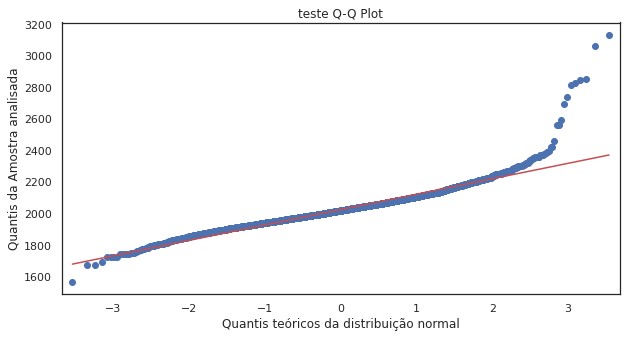

TESTE D’AGOSTINO-PEARSON
Estatistica=1981.055, p=0.000
 Amostra não se assemelha a uma gaussiana  (rejeita H0)
TESTE ANDERSON-DARLING
 Estatistica: 34.188
Significância: 15.000: Valor Crítico: 0.576, Amostra não se assemelha a uma gaussiana  (rejeita H0)
Significância: 10.000: Valor Crítico: 0.655, Amostra não se assemelha a uma gaussiana  (rejeita H0)
Significância: 5.000: Valor Crítico: 0.786, Amostra não se assemelha a uma gaussiana  (rejeita H0)
Significância: 2.500: Valor Crítico: 0.917, Amostra não se assemelha a uma gaussiana  (rejeita H0)
Significância: 1.000: Valor Crítico: 1.091, Amostra não se assemelha a uma gaussiana  (rejeita H0)
TESTE KOLMOGOROV-SMIRNOV
 1.0 0.0
 Amostra não se assemelha a uma gaussiana  (rejeita H0)


In [60]:
#@title Execute esta célula para e verificar o teste da normalidade da distribuição empirica da Média encontrada. { display-mode: "form" }
#Teste Shapiro-Wilk
alpha_n = 0.05
esw_b, p_b = stats.shapiro(y_pred_lst)

print(BOLD+RED+"TESTE DE SHAPIRO-WILK")

print(f'{DEFOUT}Estatistica Shapiro-Wilk :',esw_b,'\n','p-valor do teste :',p_b)
if p_b > alpha_n:
  shapiro1='Amostra semelhante a uma gaussiana (falha em rejeitar H0)'
else:
  shapiro1=' Amostra não se assemelha a uma gaussiana  (rejeita H0)'

print(BOLD+shapiro1)

#Teste QQ Plot
print(BOLD+RED+"TESTE Q-Q PLOT")
plt.rc("figure", figsize=(10,5))
sm.qqplot(np.array(y_pred_lst), line='s')
plt.xlabel("Quantis teóricos da distribuição normal")
plt.ylabel("Quantis da Amostra analisada")
plt.title("teste Q-Q Plot")
plt.show()

#Teste de D’Agostino-Pearson 
print(BOLD+RED+"TESTE D’AGOSTINO-PEARSON")

stat_b, p2_b = stats.normaltest(y_pred_lst)

print(f'{DEFOUT}Estatistica=%.3f, p=%.3f' % (stat_b, p2_b))
# interpretação
if p2_b > alpha_n:
  print('Amostra semelhante a uma gaussiana (falha em rejeitar H0)')
else:
  print(' Amostra não se assemelha a uma gaussiana  (rejeita H0)')

#Teste Anderson-Darling 
print(BOLD+RED+"TESTE ANDERSON-DARLING")
result_b = stats.anderson(y_pred_lst)
print(DEFOUT,'Estatistica: %.3f' % result_b.statistic)
p3_b = 0
for i in range(len(result_b.critical_values)):
  sl_b, cv_b = result_b.significance_level[i], result_b.critical_values[i]
  if result_b.statistic < result_b.critical_values[i]:
    print('Significância: %.3f: Valor Crítico: %.3f, Amostra semelhante a uma gaussiana (falha em rejeitar H0)' % (sl_b, cv_b))
  else:
    print('Significância: %.3f: Valor Crítico: %.3f, Amostra não se assemelha a uma gaussiana  (rejeita H0)' % (sl_b, cv_b))

#Teste Kolmogorov-Smirnov
print(BOLD+RED+"TESTE KOLMOGOROV-SMIRNOV")
ks_Estatistica_b, p_ks_b=stats.kstest(y_pred_lst, 'norm')

print(DEFOUT,ks_Estatistica_b, p_ks_b)

if p_ks_b>alpha_n:
  	print('Amostra semelhante a uma gaussiana (falha em rejeitar H0)')
else:
	print(' Amostra não se assemelha a uma gaussiana  (rejeita H0)')

In [61]:
#@markdown AJUSTES ALTERNATIVO, MODELO COM MENOR ERRO ABSOLUTO

def ff(xch,*params):
    '''
    Função para calcular as estimativa do modelo, dado um array dos dados tranformados
    e um vetor de coeficientes da regressão *params (x com primeira linha = 1). 
    Faz uma regressão linear com o array tranformado e depois aplica a transformação inversa 
    na variável dependente 
    '''
    try:
        yest0 = xch @ params
        yest1 = finvT(yest0)
    except:
        yest0 = yest1 = np.zeros(len(xch))

    return yest1

# Dados de entrada do avaliando

xav0 = df1.iloc[-1].values[1:-1]
xav0 = xav0.astype(float).reshape(1,len(xav0))

######
def bestoptmdl(y,xch):
    '''
    Função que recebe o vetor dos valores observados e um array dos valores transformados e retorna o vetor 
    dos coeficientes da regressão que geram o menor soma dos erros absolutos.
    '''

    def optdf3(params): 
        yest1 = ff(xch,*params)
        return sum(abs(y-yest1))

    initial_guess = b
    result_opt3 = optimize.minimize(optdf3,initial_guess, options = {'maxiter':2000}, tol = 1e-20,
                                    method = 'BFGS')

    return result_opt3['x']


valerroabs = bestoptmdl(y,xmudada)

print("Valor pelo ajuste do modelo com menor erro absoluto é R$",usd2rls(finvT(X_av1 @ valerroabs)))

Valor pelo ajuste do modelo com menor erro absoluto é R$ 1.992,70


Os coeficientes da regressão não linear são [ 4.96233667e+00  6.42179130e-02  4.50931714e+02  3.75292945e-01
 -5.46691606e-01]
A equação da estimativa será



O coeficiente de determinação da Estimativa é R²=0.921, valor Ótimo

O coeficiente de determinação da Estimativa ajustado é Ra²= 0.890 
O coeficiente de correlação da estimativa não linear é R=0.963 , correlação Fortíssima 

O valor estimado do imóvel pelo modelo não linear é R$ 2.008,63


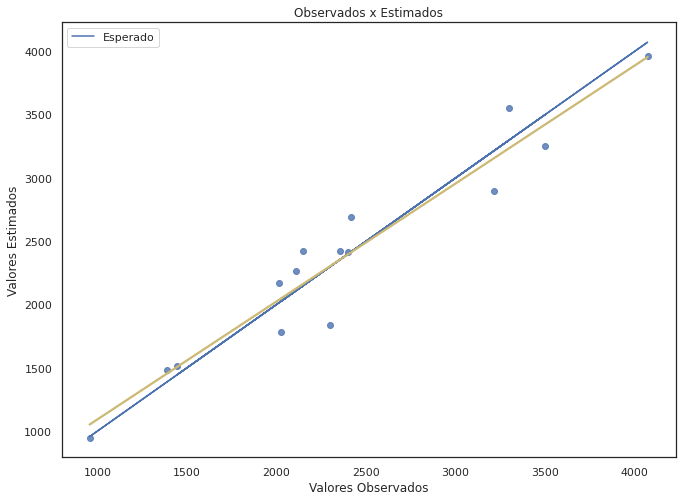

In [62]:
#@title MELHOR AJUSTE NÃO LINEAR PELOS MÍNIMOS QUADRADOS

def r2est(y,yest0):
    sqt = sum(y**2) - (sum(y))**2/len(y)
    sqe = sum((y-yest0)**2)
    return 1 - sqe / sqt

######
def best_opt_nlr2(y,xch):
    '''
    Função que recebe o vetor dos valores observados e um array dos valores transformados e retorna o vetor 
    dos coeficientes da regressão que geram o menor soma dos quadráticos
    '''

    def optr2(params): 
        yest1 = ff(xch,*params)
        return -r2est(y,yest1)

    initial_guess = b
    result_optr2 = optimize.minimize(optr2,initial_guess, options = {'maxiter':2000}, tol = 1e-20,
                                    method = 'BFGS')

    return result_optr2['x'], ff(xch,*result_optr2['x'])


if vetor_modescolha[-1] != 1:
    bnl, ynl = best_opt_nlr2(y,xmudada)

    print("Os coeficientes da regressão não linear são",bnl)

    # Concatenando os coeficientes com as variaveis
    t_est.append("")       
    zs = [f'{k:+.3f}{j}' for k,j in zip(bnl,t_est)]
    k_est = "".join(zs)

    # Juntando o lado direito com o esquerdo da equação
    m_est = y_eqest + k_est

    eqe = Eq(*map(S, m_est.split('=', 1)))
    print(BOLD+f"{RED}A equação da estimativa será")
    display(eqe)

    R2E = r2est(ynl,y)

    if R2E < 0.6:
        r2Ev=', valor muito baixo'
    elif (0.6 <= R2E) and (R2E < 0.8):
        r2Ev=', valor aceitável'
    elif (0.8<= R2E) and (R2E < 0.9):
        r2Ev=', valor Bom'
    else:
        r2Ev=', valor Ótimo'

    print(f"{DEFOUT}\nO coeficiente de determinação da Estimativa é R²={R2E:.3f}{r2Ev}"+'\n')
    print(f"O coeficiente de determinação da Estimativa ajustado é Ra²= {1-(1-R2E)*(ndados-1)/gle:.3f}",BOLD)

    r = np.corrcoef(ynl,y)[1,0]
    if r == 0:
        rv=', correlação nula'
    elif (r > 0) and (r <= 0.3):
        rv=', correlação fraca'
    elif (r > 0.3) and (r <= 0.7):
        rv=', correlação Média'
    elif (r > 0.7) and (r <= 0.9):
        rv=', correlação Forte'
    elif (r > 0.9) and (r < 1):
        rv=', correlação Fortíssima'
    else:
        rv=', correlação perfeita';

    print(f"O coeficiente de correlação da estimativa não linear é R={r:.3f}",rv,'\n')

    txtvavnl = usd2rls(finvT(X_av1 @ bnl))
    print(f"{BOLD}O valor estimado do imóvel pelo modelo não linear é R$ {txtvavnl}")


    #ols  linear_model
    sns.set(style="white")

    #Gráfico dos valores observados x estimados
    plt.rcParams['figure.figsize'] = (11,8)
    plt.plot(y,y,'-b',label = "Esperado")

    dfregnl = pd.DataFrame({'x': y, 'y': ynl})
    sns.regplot(x="x", y="y", data = dfregnl, line_kws={"color": "y"}, ci = None)
    plt.xlabel('Valores Observados')
    plt.ylabel('Valores Estimados')
    plt.title('Observados x Estimados')
    plt.legend()
    plt.show()

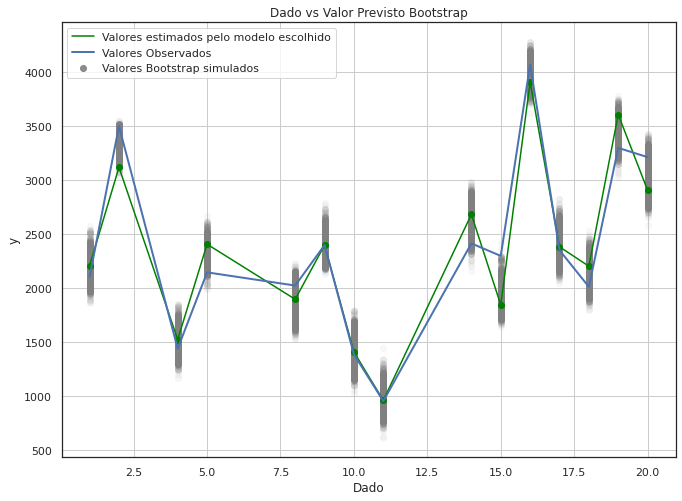

In [63]:
#@title REAMOSTRAGEM BOOTSTRAP NÃO LINEAR PELA MINIMIZAÇÃO DO ERRO QUADRÁTICO

boot_slope1 = []
boot_slope2 = []
boot_slope3 = []
boot_interc = []
y_pred_lst = []
boot_r2 = []
n_boots = 5000

sns.set(style="white")

if vetor_modescolha[-1] != 1:
    plt.figure(figsize=(11, 8))

    for k in range(n_boots):
        sample_df = df4.sample(n = ndados, replace=True, random_state = k)

        # Regressão não linear
        ybnl = finvT(np.array(sample_df.iloc[:,-1]))
        xbnl = sm.add_constant(np.array(sample_df.iloc[:,:-1]))
        b_abs, y_pred_temp = best_opt_nlr2(ybnl,xbnl)

        # append coefficients
        boot_interc.append(b_abs[0])
        boot_slope1.append(b_abs[1:])

        dds = sample_df.index

        try:
            y_pred_lst.append(finvT(X_av1 @ b_abs))
            boot_r2.append(r2est(ybnl,y_pred_temp))
            # OBSERVAÇÃO DO INTERVALO DE CONFIANÇA DE CADA DADO (REG MULTIVARIADA)
            plt.scatter(dds,y_pred_temp, color='grey', alpha=0.05)
        except:
            print("Erro na transformação")
            pass

    plt.scatter(dds,y_pred_temp, color='grey', alpha=0.9, 
                label = 'Valores Bootstrap simulados')

    plt.scatter(dados, yest, color = 'green')
                
    plt.plot(dados, yest, color = 'green',
            label = 'Valores estimados pelo modelo escolhido')
    plt.plot(dados, y, linewidth = 2, label = 'Valores Observados')
    plt.grid(True)
    plt.xlabel('Dado')
    plt.ylabel('y')
    plt.title('Dado vs Valor Previsto Bootstrap')
    plt.legend(loc="upper left")
    plt.show()

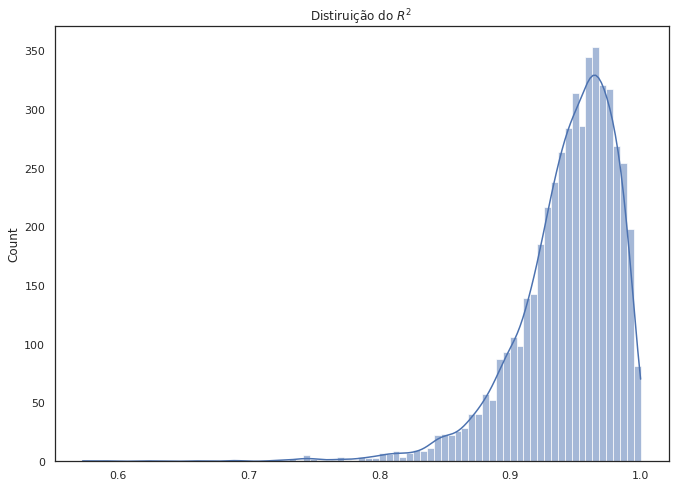

In [64]:
#@title DISTRIBUIÇÃO DO R² NÃO LINEAR
if vetor_modescolha[-1] != 1:
    plt.title('Distiruição do $R^2$')
    sns.histplot(boot_r2, kde = True);

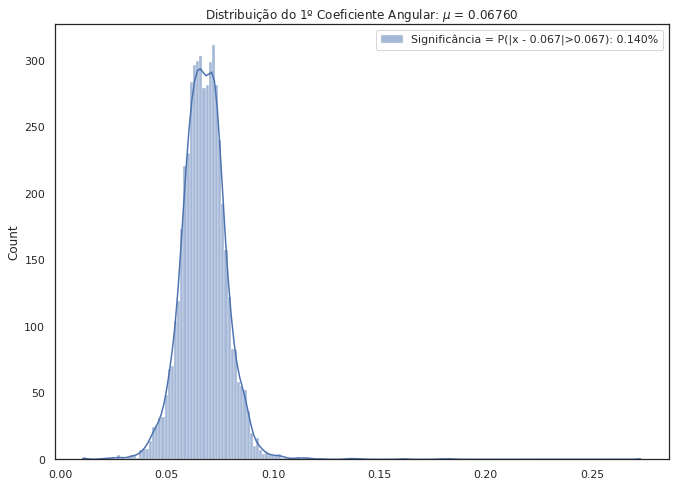

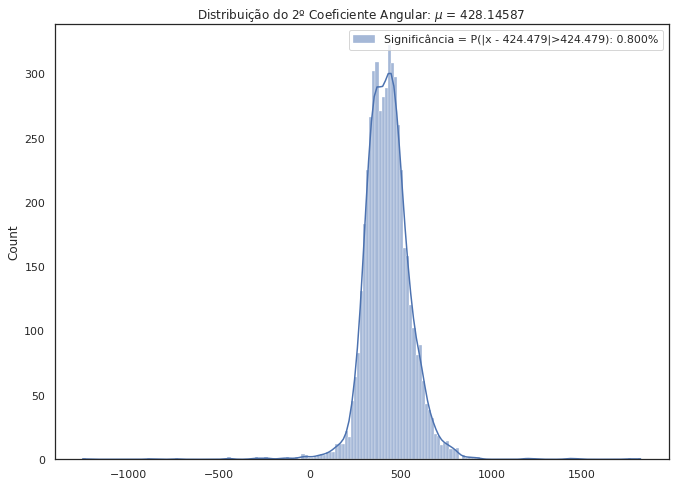

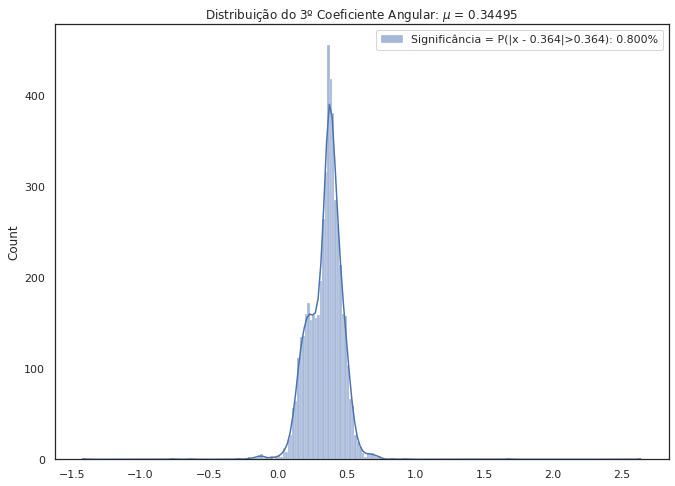

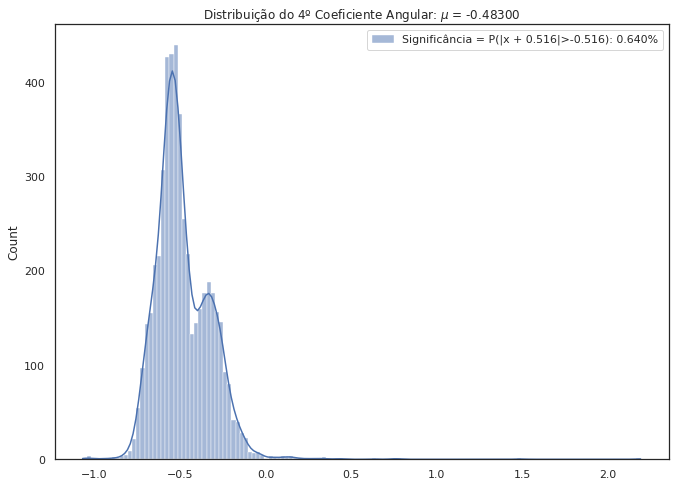

In [65]:
#@title SIGINIFICÂNCIA DO COEFICIENTE ANGULAR
boot_slope1 = np.array(boot_slope1)

for k in range(nv-1):
    if vetor_modescolha[-1] != 1:
        # Significância Beta 1
        pic = 0.9
  
        boot_slopes_ar = boot_slope1[:,k]

        mb1 = 2 * np.median(boot_slopes_ar)

        if mb1 > 0:
            sigb1 = (len(boot_slopes_ar[(boot_slopes_ar<0) | (boot_slopes_ar > mb1) ]) / n_boots)
            tstmb1 = f'Significância = P(|x - {mb1/2:.3f}|>{mb1/2:.3f}): {sigb1:.3%}'
        else:
            sigb1 = (len(boot_slopes_ar[(boot_slopes_ar>0) | (boot_slopes_ar < mb1) ]) / n_boots)
            tstmb1 = f'Significância = P(|x + {-mb1/2:.3f}|>{mb1/2:.3f}): {sigb1:.3%}'

        plt.title(f'Distribuição do {k+1}º Coeficiente Angular: $\mu$ = {boot_slopes_ar.mean():.5f}')
        sns.histplot(boot_slopes_ar, kde = True, label = tstmb1);
        plt.legend(loc = 'upper right')
        plt.show()

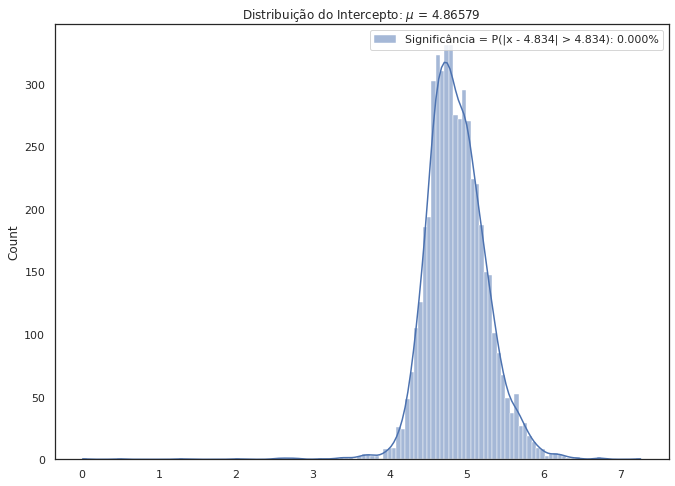

In [66]:
#@title SIGNIFICÂNCIA DO INTERCEPTO

# get cumulative probability for values

# Significância Beta 0 
if vetor_modescolha[-1] != 1:
    mb0 = 2 * np.median(boot_interc)

    boot_interc_ar = np.array(boot_interc)

    if mb0 >= 0:
        sigb0 = (len(boot_interc_ar[(boot_interc_ar<0) | (boot_interc_ar > mb0) ]) / n_boots)
        tstmb0 = f'Significância = P(|x - {mb0/2:.3f}| > {mb0/2:.3f}): {sigb0:.3%}'
    else:
        sigb0 = (len(boot_interc_ar[(boot_interc_ar>0) | (boot_interc_ar < mb0) ]) / n_boots)
        tstmb0 = f'Significância = P(|x + {-mb0/2:.3f}| > {mb0/2:.3f}): {sigb0:.3%}'



    sns.histplot(boot_interc, legend = True,kde=True, label = tstmb0); #stat="density"
    plt.title(f'Distribuição do Intercepto: $\mu$ = {boot_interc_ar.mean():.5f}')
    plt.legend(loc = 'upper right')
    plt.show()

Mediana da Distribuição Empírica 2017.894


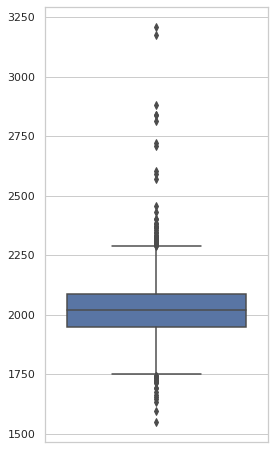

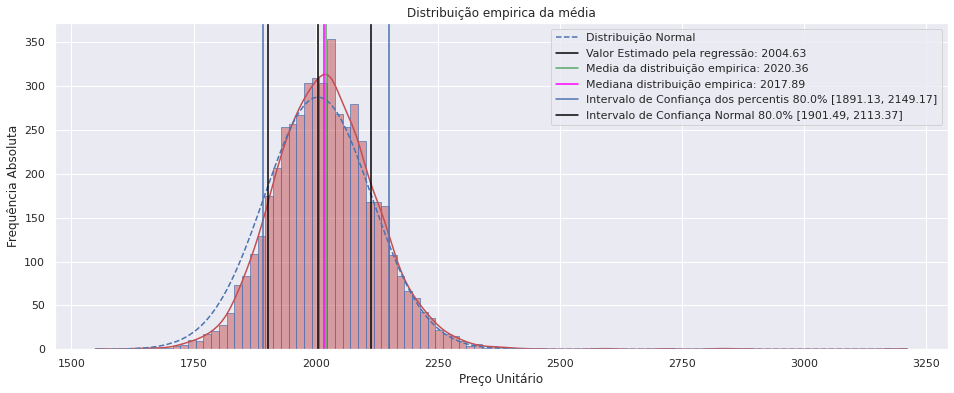

In [67]:
#@title Execute esta célula para executar a análise de Reamostragem Bootstrap da média.
if vetor_modescolha[-1] != 1:
    # Retirando valores Nan
    y_pred_lst = [x for x in y_pred_lst if str(x) != 'nan']

    Q1b, Mediana_B, Q3b = np.quantile(y_pred_lst, [0.25,0.5,0.75])
    Media_B = np.mean(y_pred_lst)

    p = 0.8 #80% de intervalo de confiança
    print( f'Mediana da Distribuição Empírica {Mediana_B:.3f}')

    # Box Plot
    plt.figure(figsize=(4, 8))
    sns.set(style="whitegrid")
    ax = sns.boxplot(y = y_pred_lst)

    # Histograma
    sns.set(style="darkgrid")
    plt.figure(figsize=(16, 6))
    sns.histplot(y_pred_lst, color='r', kde = True, edgecolor="b",linewidth=.675)


    f_obs, bins = np.histogram(y_pred_lst, bins = 'auto')
    largura_col = bins[1]-bins[0]

    xp = sorted(y_pred_lst)
    sigma = np.std(y_pred_lst, ddof = 1)

    # Adicionando uma curva distribuição normal
    ya = norm.pdf(xp, VavE, sigma)*largura_col*n_boots
    plt.plot(xp, ya, 'b--', label="Distribuição Normal")
    plt.xlabel("Preço Unitário")
    plt.ylabel("Frequência Absoluta")
    plt.title("Distribuição empirica da média")

    # Linha Vertical do Valor Estimado pela regressão
    plt.axvline(x = VavE,color='black', label = "Valor Estimado pela regressão: {}"
    .format(np.round(VavE,2))) 

    # Linha Vertical da Média da distriuição empirica
    plt.axvline(x = Media_B,color='g', label = "Media da distribuição empirica: {}"
    .format(np.round(Media_B,2))) 

    # Linha Vertical da Mediana da distriuição empirica
    plt.axvline(x = Mediana_B,color='magenta', label="Mediana distribuição empirica: {}"
    .format(np.round(Mediana_B,2))) 

    ici, ics = np.quantile(y_pred_lst, [(1- p)/2,(1+p)/2])

    # Linha Vertical do intervalor de confiança percentil da distribuição empirica
    plt.axvline(x = ici, color = 'b', 
                label = "Intervalo de Confiança dos percentis {}% ".format(p*100)+"{}"
                .format(np.round([ici, ics],2).tolist())) 
    plt.axvline(x = ics,color='b') 

    # Linha Vertical do intervalor de confiança percentil da distribuição normal
    plt.axvline(x = VEMin, color = 'black', 
                label = "Intervalo de Confiança Normal {}% ".format(p*100)+"{}"
                .format(np.round([VEMin, VEMax],2).tolist())) 
    plt.axvline(x = VEMax, color = 'black')

    plt.legend(loc = 'best')
    plt.show()

In [68]:
#@title VALORES ESTIMADOS PELO MÉTODO BOOSTSTRAP NÃO LINEAR
if vetor_modescolha[-1] != 1:
    txtvav = usd2rls(Mediana_B)
    print(f"{BOLD}O valor estimado do imóvel é de {txtvav}")


    print(f"{RED}VALORES MÍNIMOS E MÁXIMO NO INTERVALO DE CONFIANÇA DE 80% BOOTSTRAP NÃO LINEAR")

    txtVEMin = usd2rls(ici)
    print(f"{DEFOUT}O valor mínimo estimado do imóvel é R$ {txtVEMin}")

    txtVEMax = usd2rls(ics)
    print(f"{DEFOUT}O valor máximo estimado do imóvel é R$ {txtVEMax}")

    print(f"A amplitude do intervalo de confiança da estimativa é {(ics-ici)/Mediana_B:.2%}")

O valor estimado do imóvel é de 2.017,89
VALORES MÍNIMOS E MÁXIMO NO INTERVALO DE CONFIANÇA DE 80% BOOTSTRAP NÃO LINEAR
O valor mínimo estimado do imóvel é R$ 1.891,13
O valor máximo estimado do imóvel é R$ 2.149,17
A amplitude do intervalo de confiança da estimativa é 12.79%
